# Projet proba Num

## Introduction :


Dans de nombreux problèmes de finance, le pricing et la couverture d’options se ramènent à l’évaluation d’intégrales de grande dimension. La méthode de Monte Carlo est fréquemment utilisée grâce à sa flexibilité (elle s’applique à n’importe quel modèle de diffusion et peut gérer autant d’actifs que nécessaire), et parce que sa variance ne dépend pas de la dimension. Toutefois, la convergence d’un estimateur Monte Carlo est de l’ordre de
$1/\sqrt{N}$ (où $N$ est le nombre de simulations) et peut s’avérer lente lorsque la variance $σ^2$ de la fonction à intégrer est élevée.

Pour accélérer cette convergence, on se tourne souvent vers des techniques de réduction de variance comme l’importance sampling, la stratification ou encore les variables de contrôle. Dans ce projet, nous proposons deux approches innovantes s’appuyant sur l’utilisation de réseaux de neurones :

Réduction de dimension pour les problèmes à “faible dimension effective”
Même si le problème est formellement de dimension élevée, sa complexité est parfois concentrée dans un nombre restreint de variables. En identifiant et en isolant ces variables-clés via un réseau de neurones, on réduit la dimension de manière significative. On peut alors recourir à des méthodes d’intégration numériques plus rapides (par exemple, les quadratures gaussiennes) pour calculer l’espérance recherchée.
Construction d’une variable de contrôle via un réseau de neurones
Les variables de contrôle consistent à trouver une fonction $h(X)$ très corrélée à la fonction à intégrer $f(X)$, dont l’espérance est plus simple à calculer exactement ou avec un biais négligeable. Ici, on entraîne un réseau de neurones qui apprend directement le comportement de $f(X)$ (en tenant compte du modèle de diffusion, de la discrétisation et du payoff). Cette approche produit naturellement une variable de contrôle hautement corrélée à
$f$ et intégrable de façon beaucoup plus précise.
Grâce à ces deux méthodes, nous pouvons améliorer considérablement la convergence des estimateurs Monte Carlo dans les situations exigeantes en finance, qu’il s’agisse de modèles de diffusion complexes ou de portefeuilles de grande dimension.

## Import necessaire

In [18]:
import math
import time
import os
import pickle
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA

from numpy.random import default_rng, SeedSequence
sq = SeedSequence()
seed = sq.entropy        # on sauve la graine pour reproduire les résultats
rng = default_rng(sq)

import torch

dtype = torch.float32
device = torch.device("cpu")
rng_torch = torch.Generator(device=device)
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import DataLoader

## Implémentation en Numpy pour Black&Scholes

Nous definissons une fonction de Monte Carlo.

C'est une méthode numérique basée sur la loi des grands nombres et le théorème
central limite pour donner un intervalle de confiance (asymptotique).

La seule valeur moyenne $\bar I_M = \frac{1}{M} \sum_{k=1}^M X_k$ d’un
échantillon $(X_1, \dots, X_M)$ n’est pas suffisante pour déterminer
$I = \mathbf{E}[X_1]$. Il faut toujours renvoyer la valeur de
l’estimateur $I_M$ et son intervalle de confiance $$
    I \in \Bigl] \bar I_M- q_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{M}};
    \bar I_M + q_{1 - \frac{\alpha}{2}} \frac{\sigma}{\sqrt{M}}
    \Bigr[ \quad \text{avec probabilité $p = 1-\alpha \in ]0,1[$}
$$ où $q_{1-\frac{\alpha}{2}}$ est le quantile de niveau
$1-\frac{\alpha}{2}$ de la loi normale centrée réduite et
$\sigma^2 = \operatorname{var}(X_1)$.  
Pour $\alpha = 0.05$ c’est à dire $p = 0.95$ on a
$1-\frac{\alpha}{2} = 1.96$.

In [19]:
def monte_carlo_classique(sampling_function, epsilon: float, mod,
                         batch_size: int,
                         proba: float = 0.95) -> dict:
    """
    Effectue une estimation Monte Carlo adaptative jusqu'à ce que l'intervalle
    de confiance de la moyenne soit inférieur à epsilon.

    Args:
    - sampling_function (callable): Une fonction qui produit des échantillons
      de taille donnée en argument.
    - epsilon (float): La taille maximum tolérée pour l'IC.
    - proba (float): Niveau de confiance pour l'intervalle (défaut: 0.95).
    - batch_size (int): Taille du batch pour les simulations.

    Returns:
    - dict: Un dictionnaire contenant les valeurs suivantes :
        - "mean" (float): Moyenne de l'échantillon final.
        - "var" (float): Variance de l'échantillon final.
        - "ci_size" (float): Taille de l'intervalle de confiance.
        - "samples_size" (int): Nombre de tirages effectués.
        - "time (s)" (float): Temps d'execution en secondes.
    """
    alpha = 1 - proba
    quantile = sps.norm.ppf(1 - alpha / 2)

    sum_, sum2_, size_ = 0, 0, 0
    start = time.time()
    with tqdm(total=None, desc="Monte Carlo") as pbar:
        while True:
            # Génération d'un nouveau batch d'échantillons
            samples = sampling_function(batch_size)
            sum_ += samples.sum().item()
            sum2_ += (samples**2).sum().item()
            size_ += batch_size

            mean = sum_ / size_
            var = size_ / (size_-1) * (sum2_ / size_ - mean**2)
            ci_size = 2 * quantile * math.sqrt(var / size_)

            # Mise à jour de tqdm avec la taille de l'IC actuelle
            pbar.set_postfix({"IC_size": ci_size, "mean": mean, "var": var})
            pbar.update(batch_size)

            if ci_size <= epsilon:
                break
    stop = time.time()
    return {
        "mean": mean,
        "var": var,
        "ci_size": ci_size,
        "samples_size": size_,
        "time (s)": stop-start,
    }

Ensuite nous allons définir 4 type de payoffs :
        
##### 1. **Basket Option (Option Panier)**

Le **payoff** d'une option panier est basé sur la moyenne ou la somme des prix de plusieurs actifs sous-jacents. Si $( S_1, S_2, \dots, S_d )$ représentent les prix des actifs sous-jacents à l'échéance, le payoff peut être formulé comme suit :

$$\text{Payoff}_{\text{Basket}} = \max \left( \frac{1}{d} \sum_{i=1}^d S_i - K, 0 \right)$$

Où :
- $( K )$ est le prix d'exercice de l'option.
- $( d )$ est le nombre d'actifs dans le panier.

Cela représente une option sur la moyenne des prix des actifs sous-jacents.

##### 2. **Worst-of Option (Option "Pire des")**

Une option "pire des" est une option dont le payoff dépend du pire (le minimum) des prix de plusieurs actifs sous-jacents. Le payoff est donné par la formule suivante :


$$\text{Payoff}_{\text{Worst-of}} = \max \left( \min \left(S_1, S_2, \dots, S_n \right) - K, 0 \right)$$

Où :
- $( S_1, S_2, \dots, S_n )$ sont les prix des actifs sous-jacents à l'échéance.
- $( K )$ est le prix d'exercice de l'option.

###### 3. **Asian Option (Option Asiatique)**

Le **payoff** d'une option asiatique dépend de la moyenne des prix des actifs sous-jacents pendant toute la durée de vie de l'option. La formule est la suivante :


$$\text{Payoff}_{\text{Asian}} = \max \left( \overline{S} - K, 0 \right)$$

Où :
- $( \overline{S} )$ est la moyenne des prix des actifs sous-jacents pendant la période d'option.
- $( K )$ est le prix d'exercice de l'option.

La moyenne est généralement une moyenne arithmétique, mais elle peut aussi être géométrique.

###### 4. **Digital Option (Option Binaire)**

Une **option binaire** (ou option digitale) donne un payoff fixe si une condition est remplie à l'échéance. Le payoff est exprimé comme suit :


$$\text{Payoff}_{\text{Digit}} = \begin{cases} 1 & \text{si } S_T > K \\ 0 & \text{sinon} \end{cases}$$

Où :
- $( S_T )$ est le prix de l'actif sous-jacent à l'échéance.
- $( K )$ est le prix d'exercice.

Cette option est également appelée "option tout ou rien" car elle paie une somme fixe (souvent 1) si la condition est remplie, sinon elle ne paie rien.


In [20]:
def Basket(K, S, weight, type_prix):
    """
    Option panier (basket)
    K : Prix d'exercice
    S : Liste des prix des actifs sous-jacents
    weight : Liste des poids associés aux actifs
    type_prix : "Call" ou "Put"
    """
    if type_prix not in ["Call", "Put"]:
        raise ValueError("type_prix ne peut que : 'Call' ou 'Put'")
    else:
        # Calcul de la somme pondérée des prix des actifs sous-jacents
        weighted_sum = np.dot(S[:, :, -1], weight)  # Produit scalaire entre les prix et les poids
        if type_prix == "Call":
            payoff = np.maximum(weighted_sum - K, 0)  # Call basket
        else:
            payoff = np.maximum(K - weighted_sum, 0)  # Put basket
        return payoff

def Worst_of(K, S, type_prix):
    """
    Option Worst-of
    K : Prix d'exercice
    S : Liste des prix des actifs sous-jacents
    type_prix : "Call" ou "Put"
    """
    if type_prix not in ["Call", "Put"]:
        raise ValueError("type_prix ne peut que : 'Call' ou 'Put'")
    else:
        # Trouver le prix minimum parmi les actifs sous-jacents
        worst_price = np.min(S[:, :, -1], axis=1)
        if type_prix == "Call":
            payoff = np.maximum(worst_price - K, 0)  # Call Worst-of
        else:
            payoff = np.maximum(K - worst_price, 0)  # Put Worst-of
        return payoff


def Asian(K, S, weight, type_prix):
    """
    Option asiatique
    K : Prix d'exercice
    S : Prix de l'actif sous-jacent
    weight : Poids (peut être une liste pour les paniers d'actifs)
    type_prix : "Call" ou "Put"
    """
    # Vérification de la dimension de S et de w
    size, d, N = S.shape
    if len(weight) != d:
        raise ValueError("Le nombre de poids w doit être égal au nombre de moments j dans S.")

    #weight_expanded = weight.reshape(1, -1, 1)
    # Calcul de la somme pondérée des prix pour chaque instant t_i
    weighted_sums = np.sum(S * weight.reshape(1, -1, 1), axis=1)  # Somme pondérée sur chaque période t_i

    # Moyenne de ces sommes pondérées
    average_weighted_sum = np.mean(weighted_sums, axis=1)

    # Calcul du payoff selon le type d'option
    if type_prix == "Call":
        payoff = np.maximum(0.0, average_weighted_sum - K)
    elif type_prix == "Put":
        payoff = np.maximum(0.0, K - average_weighted_sum)
    else:
        raise ValueError("type_prix doit être 'Call' ou 'Put'")

    return payoff


def A_digit(K, S, weight, G, type_prix):
    """
    Option à paiement numérique
    K : Prix d'exercice
    S : Liste des prix des actifs sous-jacents
    weight : Poids des actifs (si applicable)
    type_prix : "Call" ou "Put"
    """
    weighted_sum = np.dot(S[:, :, -1], weight)
    if type_prix not in ["Call", "Put"]:
        raise ValueError("type_prix ne peut que : 'Call' ou 'Put'")
    else:
        # Dans un cas typique d'option à digital, on a un paiement fixe si S dépasse K
        if type_prix == "Call":
            payoff= np.where(weighted_sum > K, G, 0)  # Option call numérique
        else:
            payoff= np.where(weighted_sum < K, G, 0)  # Option put numérique

        return payoff

De plus nous allons nous basé pour le debut de ce projet sur le modèle de Black&Scholes.
Pour ceci nous definissons une fonction qui va créer un dictionnaire qui contient les parametres necessaires au modele.

#### Modèle de Black-Scholes en Équation Différentielle Stochastique (EDS)

Le modèle de Black-Scholes pour le prix d'un actif $( S_t )$ évolue selon l'équation différentielle stochastique suivante :

#### 1. **Modèle de Black-Scholes**

L'EDS du modèle de Black-Scholes est donnée par :


$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$


où :
- $( S_t )$ est le prix de l'actif sous-jacent à l'instant $( t )$,
- $( \mu )$ est le taux de rendement attendu (drift),
- $( \sigma )$ est la volatilité de l'actif,
- $( W_t )$ est un mouvement brownien standard (processus de Wiener),
- $( dW_t )$ est l'incrément du mouvement brownien sur un petit intervalle de temps $( dt )$.

In [21]:
def model_bs(d, r, S0, sigma, correlation, T):
    """
    Initialise les paramètres du modèle multidimensionnel de Black-Scholes.

    Args:
    - d (int): Dimension, représentant le nombre d'actifs dans le panier.
    - r (float): Taux d'intérêt sans risque.
    - S0 (np.ndarray): Vecteur des prix initiaux des actifs, de taille (d,).
    - sigma (np.ndarray): Vecteur des volatilités des actifs, de taille (d,).
    - correlation (np.ndarray): Matrice de corrélation, de taille (d, d).
    - T (float): Maturité de l'option (temps jusqu'à l'échéance).

    Returns:
    - dict: Un dictionnaire contenant les paramètres du modèle.
    """
    return {
        "d": d,
        "r": r,
        "S0": S0,
        "sigma": sigma,
        "mu": r - 0.5 * sigma**2,
        "correlation": correlation,
        "correlation_cholesky": np.linalg.cholesky(correlation),
        "T": T,
        "actualization": math.exp(-r * T)
    }

In [22]:
d=10
rho = 0.75

bs = model_bs(d=d, r=0.1, S0=np.full((d), 100),
              sigma=np.full((d), 0.4),
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1)

Viens ensuite les fonctions de création des actifs, et de calculs des payoffs.

##### 1. **Payoff(K, S, weight, G, type_prix, type_option)**

La fonction `Payoff` calcule le payoff d'une option en fonction de son type.

##### 2. **phi(bs, Gn, N=100)**

La fonction `phi` simule les trajectoires des prix des actifs sous-jacents à l'aide d'un modèle. Elle prend en entrée les paramètres du modèle (initialisés via model_bs), ainsi que les variables normales standard pour générer les trajectoires.

##### 3. **sampling_payoffs_classique(type_option, size, K, weight, G, mod, rng, N, type_prix)**

La fonction `sampling_payoffs_classique` génère des échantillons de payoffs pour un type d'option donné. Elle simule les trajectoires des prix des actifs sous-jacents, puis calcule le payoff selon le type d'option choisi.

Pour ceci nous avons besoin de ces formules :

#### 2. **Résolution de l'EDS (Formule Fermée)**

Pour résoudre cette EDS, nous utilisons la méthode d'Ïto. La solution de l'EDS est obtenue par l'intégration de l'EDS à partir du temps initial $( t = 0 )$, en supposant que le prix initial est $( S_0 )$ :


$$S_t = S_0 \exp\left( \left( \mu - \frac{1}{2} \sigma^2 \right) t + \sigma W_t \right)$$


Cela peut être interprété comme une dynamique de type log-normale, où :
- Le facteur $( \mu - \frac{1}{2} \sigma^2 )$ correspond à la tendance moyenne corrigée par la volatilité,
- $( \sigma W_t )$ représente le choc stochastique à chaque instant de temps $( t )$.

#### 3. **Calcul de $( S_{t+1} )$ en fonction de $( S_t )$**

En pratique, le modèle de Black-Scholes est souvent utilisé pour générer des trajectoires discrètes. À chaque pas de temps $( \Delta t )$, le prix de l'actif à l'instant $( t+1 )$ est obtenu à partir du prix à l'instant $( t )$ de la manière suivante :


$$S_{t+1} = S_t \exp\left( \left( \mu - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} W_t \right)$$

où :
- $( \Delta t )$ est le pas de temps discret,
- $( W_t )$ est un mouvement brownien standard

Cela permet de simuler l'évolution discrète des prix des actifs sous-jacents en utilisant des tirages aléatoires pour $( G_n )$.

#### 4. **Interprétation et Utilisation**

Cette équation montre que la variation du prix de l'actif $( S_t )$ entre deux instants successifs dépend d'une tendance déterminée par $( \mu )$, ainsi que d'un choc stochastique proportionnel à $( \sigma )$, représentant la volatilité de l'actif. La relation obtenue pour $( S_{t+1} )$ permet de simuler les trajectoires de prix dans un modèle discret.

In [23]:
def Payoff(K, S, weight, G, type_prix, type_option):
    if type_option not in ["Basket", "Asian", "A_digit", "Worst_of"]:
        raise ValueError(f"type_option doit etre : 'Basket', 'Asian', 'A_digit', 'Worst_of'")
    else :
        if type_option=="Basket":
            return Basket(K, S, weight, type_prix)
        if type_option=="Asian":
            return Asian(K, S, weight, type_prix)
        if type_option=="Worst_of":
            return Worst_of(K, S, type_prix)
        if type_option=="A_digit":
            return A_digit(K, S, weight, G, type_prix)



def phi(bs, Gn, N=100):
    """
    Calcule les trajectoires complètes des prix des actifs sous-jacents.

    Args:
    - bs (dict): Paramètres du modèle de Black-Scholes (initialisés par model_bs).
    - Gn (np.ndarray): Variables normales standard, taille (size, d, N).
    - N (int): Nombre de pas de temps.

    Returns:
    - np.ndarray: Trajectoires simulées des actifs sous-jacents de taille (size, d, N).
    """
    # Discrétisation du temps
    dt = bs["T"] / (N)  # Pas de temps

    # Initialisation des trajectoires
    trajectoires = np.zeros((Gn.shape[0], bs["d"], N))  # (size, d, N)

    # Conditions initiales
    # Remarque : bs["S0"] est déjà un vecteur de taille (d,)
    # Nous allons directement l'utiliser pour chaque simulation
    for i in range(Gn.shape[0]):  # Pour chaque simulation
        trajectoires[i, :, 0] = bs["S0"]  # Le prix initial de chaque actif

    # Simulation des trajectoires pour chaque actif
    for t in range(1, N):  # De t=1 à t=N-1 (car nous ne comptons pas t=0 ici)
        # Chocs de prix pour chaque actif à chaque étape
        dW = Gn[:, :, t-1]  # Les chocs à chaque pas de temps

        # Calcul du terme mu * dt (comportement moyen de chaque actif)
        mu_T = bs["mu"] * dt

        # Calcul des chocs de volatilité (matrice de covariance Cholesky appliquée)
        sig_T = bs["sigma"] * np.sqrt(dt)  # Volatilité ajustée pour le pas de temps
        dW_adjusted = np.einsum('ij,pj->pi', bs["correlation_cholesky"], dW)  # Applique la corrélation

        # Calcul des prix à l'instant t+1 pour chaque actif
        trajectoires[:, :, t] = trajectoires[:, :, t-1] * np.exp(mu_T + sig_T * dW_adjusted)

    return trajectoires


def sampling_payoffs_classique(type_option, size, K, weight, G, mod, rng, N, type_prix):
    #print("size = ",size)
    Gn = rng.standard_normal((size, mod["d"],N))
    S = phi(mod, Gn, N)
    payoffs = Payoff(K, S, weight, G, type_prix, type_option)
    #print(payoffs)
    return mod["actualization"] * payoffs



Enfin nous definissons une fonction d'utilisation :

In [24]:
def run_classique(function, epsilon, batch_size, type_prix, mod, **kwargs):
    result = {}
    for type_option in ["Basket", "Asian", "A_digit", "Worst_of"]:
        if type_option=="Worst_of":
            type_prix="Put"
        result[type_option] = monte_carlo_classique(
            sampling_function=lambda batch_size: function(
                type_option=type_option, type_prix=type_prix, size=batch_size, mod=mod,**kwargs
            ),
            mod=mod,
            epsilon=epsilon,
            batch_size=batch_size
        )

    # Transformer les résultats en DataFrame pour une visualisation claire
    result_df = pd.DataFrame(result)
    result_df.columns.name = "Payoff"
    return result_df

## Transformation en PyTorch

Afin d'accelerer les calculs et par la suite utiliser des reseaux de neurones, nous allons implementer le meme code mais en version pytorch

Notons que les fonctions `monte_carlo` et `sampling_payoffs` sont générique et fonctionne donc avec d'autre modèle que l'on implementeras dans la suite.

In [25]:
def monte_carlo(sampling_function, epsilon: float, mod,
                         batch_size: int,
                         proba: float = 0.95) -> dict:
    """
    Effectue une estimation Monte Carlo adaptative jusqu'à ce que l'intervalle
    de confiance de la moyenne soit inférieur à epsilon.

    Args:
    - sampling_function (callable): Une fonction qui produit des échantillons
      de taille donnée en argument.
    - epsilon (float): La taille maximum tolérée pour l'IC.
    - proba (float): Niveau de confiance pour l'intervalle (défaut: 0.95).
    - batch_size (int): Taille du batch pour les simulations.

    Returns:
    - dict: Un dictionnaire contenant les valeurs suivantes :
        - "mean" (float): Moyenne de l'échantillon final.
        - "var" (float): Variance de l'échantillon final.
        - "ci_size" (float): Taille de l'intervalle de confiance.
        - "samples_size" (int): Nombre de tirages effectués.
        - "time (s)" (float): Temps d'execution en secondes.
    """
    alpha = 1 - proba
    quantile = sps.norm.ppf(1 - alpha / 2)

    sum_, sum2_, size_ = 0, 0, 0
    start = time.time()
    with tqdm(total=None, desc="Monte Carlo") as pbar:
        while True:
            Gn = torch.randn(batch_size, mod["d"], N)
            # Génération d'un nouveau batch d'échantillons
            samples = sampling_function(Gn, batch_size)
            sum_ += samples.sum().item()
            sum2_ += (samples**2).sum().item()
            size_ += batch_size

            mean = sum_ / size_
            var = size_ / (size_-1) * (sum2_ / size_ - mean**2)
            ci_size = 2 * quantile * math.sqrt(var / size_)

            # Mise à jour de tqdm avec la taille de l'IC actuelle
            pbar.set_postfix({"IC_size": ci_size, "mean": mean, "var": var})
            pbar.update(batch_size)

            if ci_size <= epsilon:
                break
    stop = time.time()
    return {
        "mean": mean,
        "var": var,
        "ci_size": ci_size,
        "samples_size": size_,
        "time (s)": stop-start,
    }

def model_bs_torch(d, r, S0, sigma, correlation, T, device=None):
    """
    Initialise les paramètres du modèle multidimensionnel de Black-Scholes en PyTorch.

    Args:
    - d (int): Dimension, représentant le nombre d'actifs dans le panier.
    - r (float): Taux d'intérêt sans risque.
    - S0 (np.ndarray): Vecteur des prix initiaux des actifs, de taille (d,).
    - sigma (np.ndarray): Vecteur des volatilités des actifs, de taille (d,).
    - correlation (np.ndarray): Matrice de corrélation, de taille (d, d).
    - T (float): Maturité de l'option (temps jusqu'à l'échéance).
    - device (torch.device): Périphérique sur lequel les tensors seront placés, comme 'cuda' ou 'cpu'.

    Returns:
    - dict: Un dictionnaire contenant les paramètres du modèle sous forme de tensors PyTorch.
    """

    device = device or torch.device("cpu")

    bs_torch = {
        "d": d,
        "r": torch.tensor(r, dtype=torch.float32, device=device),
        "S0": torch.tensor(S0, dtype=torch.float32, device=device),
        "sigma": torch.tensor(sigma, dtype=torch.float32, device=device),
        "mu": torch.tensor(r - 0.5 * sigma**2, dtype=torch.float32, device=device),
        "correlation": torch.tensor(correlation, dtype=torch.float32, device=device),
        "correlation_cholesky": torch.tensor(np.linalg.cholesky(correlation), dtype=torch.float32, device=device),
        "T": torch.tensor(T, dtype=torch.float32, device=device),
        "actualization": torch.tensor(math.exp(-r * T), dtype=torch.float32, device=device)
    }
    return bs_torch


def Asian_torch(K, S, weight, type_prix):
    """
    Option asiatique
    K : Prix d'exercice
    S : Prix de l'actif sous-jacent (torch.Tensor)
    weight : Poids (torch.Tensor)
    type_prix : "Call" ou "Put"
    """
    size, d, N = S.shape
    if len(weight) != d:
        raise ValueError("Le nombre de poids doit être égal au nombre d'actifs sous-jacents.")

    weighted_sums = torch.sum(S * weight.unsqueeze(0).unsqueeze(2), axis=1)

    average_weighted_sum = torch.mean(weighted_sums, axis=1)

    if type_prix == "Call":
        payoff = torch.maximum(average_weighted_sum - K, torch.zeros_like(average_weighted_sum))
    elif type_prix == "Put":
        payoff = torch.maximum(K - average_weighted_sum, torch.zeros_like(average_weighted_sum))
    else:
        raise ValueError("type_prix doit être 'Call' ou 'Put'")

    return payoff

def Basket_torch(K, S, weight, type_prix):
    """
    Option panier (basket)
    K : Prix d'exercice
    S : Liste des prix des actifs sous-jacents (torch.Tensor)
    weight : Liste des poids associés aux actifs (torch.Tensor)
    type_prix : "Call" ou "Put"
    """
    if type_prix not in ["Call", "Put"]:
        raise ValueError("type_prix ne peut que : 'Call' ou 'Put'")

    weighted_sum = torch.matmul(S[:, :, -1], weight)

    if type_prix == "Call":
        payoff = torch.maximum(weighted_sum - K, torch.zeros_like(weighted_sum))  # Call basket
    else:
        payoff = torch.maximum(K - weighted_sum, torch.zeros_like(weighted_sum))  # Put basket

    return payoff

def Worst_of_torch(K, S, type_prix):
    """
    Option Worst-of
    K : Prix d'exercice
    S : Liste des prix des actifs sous-jacents (torch.Tensor)
    type_prix : "Call" ou "Put"
    """
    if type_prix not in ["Call", "Put"]:
        raise ValueError("type_prix ne peut que : 'Call' ou 'Put'")

    worst_price = torch.min(S[:, :, -1], axis=1)[0]

    if type_prix == "Call":
        payoff = torch.maximum(worst_price - K, torch.zeros_like(worst_price))
    else:
        payoff = torch.maximum(K - worst_price, torch.zeros_like(worst_price))

    return payoff

def A_digit_torch(K, S, weight, G, type_prix):
    """
    Option à paiement numérique
    K : Prix d'exercice
    S : Liste des prix des actifs sous-jacents (torch.Tensor)
    weight : Poids des actifs (torch.Tensor)
    type_prix : "Call" ou "Put"
    """
    weighted_sum = torch.matmul(S[:, :, -1], weight)  # Calcul de la somme pondérée des prix

    if type_prix not in ["Call", "Put"]:
        raise ValueError("type_prix ne peut que : 'Call' ou 'Put'")

    if type_prix == "Call":
        payoff = torch.where(weighted_sum > K, G, torch.zeros_like(weighted_sum))  # Option call numérique
    else:
        payoff = torch.where(weighted_sum < K, G, torch.zeros_like(weighted_sum))  # Option put numérique

    return payoff

def Payoff_torch(K, S, weight, G, type_prix, type_option):
    if type_option not in ["Basket", "Asian", "A_digit", "Worst_of"]:
        raise ValueError(f"type_option doit etre : 'Basket', 'Asian', 'A_digit', 'Worst_of'")
    else :
        if type_option=="Basket":
            return Basket_torch(K, S, weight, type_prix)
        if type_option=="Asian":
            return Asian_torch(K, S, weight, type_prix)
        if type_option=="Worst_of":
            return Worst_of_torch(K, S, type_prix)
        if type_option=="A_digit":
            return A_digit_torch(K, S, weight, G, type_prix)

def phi_torch(bs, Gn, N):
    """
    Calcule les trajectoires complètes des prix des actifs sous-jacents en utilisant PyTorch.

    Args:
    - bs (dict): Paramètres du modèle de Black-Scholes (initialisés par model_bs).
    - Gn (torch.Tensor): Variables normales standard, taille (size, d, N).
    - N (int): Nombre de pas de temps.

    Returns:
    - torch.Tensor: Trajectoires simulées des actifs sous-jacents de taille (size, d, N).
    """
    # Discrétisation du temps
    dt = bs["T"] / (N)  # Pas de temps

    # Initialisation des trajectoires
    trajectoires = torch.zeros((Gn.shape[0], bs["d"], N))  # (size, d, N)

    # Conditions initiales
    # Remarque : bs["S0"] est déjà un vecteur de taille (d,)
    trajectoires[:, :, 0] = bs["S0"].unsqueeze(0)  # Le prix initial de chaque actif

    # Simulation des trajectoires pour chaque actif
    for t in range(1, N):  # De t=1 à t=N-1 (car nous ne comptons pas t=0 ici)
        # Chocs de prix pour chaque actif à chaque étape
        dW = Gn[:, :, t-1]  # Les chocs à chaque pas de temps
        # Calcul du terme mu * dt (comportement moyen de chaque actif)
        mu_T = bs["mu"] * dt

        # Calcul des chocs de volatilité (matrice de covariance Cholesky appliquée)
        sig_T = bs["sigma"] * torch.sqrt(dt)  # Volatilité ajustée pour le pas de temps
        dW_adjusted = torch.matmul(dW, bs["correlation_cholesky"].T)  # Applique la corrélation

        # Calcul des prix à l'instant t+1 pour chaque actif
        trajectoires[:, :, t] = trajectoires[:, :, t-1] * torch.exp(mu_T + sig_T * dW_adjusted)

    return trajectoires



def sampling_payoffs(type_option, type_prix, size, K, weight, G, Gn, mod, rng, N, device=None):
    """
    Calcule les payoffs pour un type d'option donné en utilisant des trajectoires simulées via PyTorch.

    Args:
    - type_option (str): Type d'option ("Basket", "Asian", "Worst_of", "A_digit").
    - size (int): Nombre de simulations.
    - K (float): Prix d'exercice.
    - weight (torch.Tensor): Poids associés aux actifs.
    - G (float): Paiement pour l'option numérique (le cas échéant).
    - bs (dict): Paramètres du modèle de Black-Scholes (dictionnaire).
    - rng (np.random.Generator): Générateur de nombres aléatoires.
    - N (int): Nombre de pas de temps.
    - type_prix (str): Type de l'option ("Call" ou "Put").

    Returns:
    - torch.Tensor: Payoffs actualisés pour chaque simulation.
    """
    # Si device n'est pas spécifié, utiliser le CPU par défaut
    device = device or torch.device("cpu")

    # Générer les variables normales standard avec PyTorch
    #Gn = torch.randn(size, bs["d"], N)  # Variables normales standard (size, d, N)

    # Calculer les trajectoires des prix des actifs
    if "local_vol_func" in mod:
        S = phi_local_vol_torch(mod, Gn, N)
    elif "nu" in mod:
        S = phi_heston_torch(mod, Gn, N)
    else:
        S = phi_torch(mod, Gn, N)

    # Calculer les payoffs pour le type d'option donné
    payoffs = Payoff_torch(K, S, weight, G, type_prix, type_option)

    # Retourner les payoffs actualisés
    return mod["actualization"] * payoffs
    #return  payoffs

def run(function, epsilon, batch_size, type_prix, mod, **kwargs):
    result = {}
    for type_option in ["Basket", "Asian", "A_digit", "Worst_of"]:
        if type_option=="Worst_of":
            type_prix="Put"
        result[type_option] = monte_carlo(
            sampling_function=lambda Z, batch_size: function(
                type_option=type_option, type_prix=type_prix, size=batch_size, Gn=Z, mod=mod,**kwargs
            ),
            mod=mod,
            epsilon=epsilon,
            batch_size=batch_size
        )

    # Transformer les résultats en DataFrame pour une visualisation claire
    result_df = pd.DataFrame(result)
    result_df.columns.name = "Payoff"
    return result_df

d=10
rho = 0.75

bs_torch= model_bs_torch(d=d, r=0.1, S0=np.full((d), 100),
              sigma=np.full((d), 0.4),
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1,device=device)

### Mise en place des reseaux de neurones

#### Reseaux de reduction de dimension

nous avons avons besoin de normaliser nos données avant de les placé dans un reseau de données. Pour ceci nous definnissons une fonction `normalize_data` qui retire la moyenne est divise par l'ecart type.
Nous conservons ces parametres afin de renormaliser nos resultat en sortie.

In [26]:
def normalize_data(data):
    """
    Normalise les données PyTorch.

    Args:
        data (torch.Tensor): Les données à normaliser.

    Returns:
        tuple: (data_normalized, params)
            - data_normalized (torch.Tensor): Données normalisées.
            - params (dict): Paramètres de normalisation pour dénormaliser.
    """
    mean = data.mean()
    std = data.std()
    data_normalized = (data - mean) / (std + 1e-8)  # Ajout de 1e-8 pour éviter la division par 0
    params = {"mean": mean, "std": std}

    return data_normalized, params

### Réseau de Neurones : `DimensionReducerNN`

Le réseau de neurones `DimensionReducerNN` est conçu pour réduire une entrée multidimensionnelle (par exemple, une matrice de taille $(d \times N))$ à une sortie unidimensionnelle (par exemple, un payoff). Il applique une réduction de dimension basée sur une couche linéaire, suivie de plusieurs couches cachées pour reconstruire le payoff.

#### 1. **Paramètres du Modèle**

- **`input_size` (int)** : Taille aplatie de l'entrée $( (d \times N) )$, où $(d)$ représente le nombre de caractéristiques et $(N)$ la longueur des séquences.
- **`n` (int)** : Dimension réduite choisie par nous.
- **`hidden_sizes` (list of int)** : Liste des tailles des couches cachées. Chaque élément de cette liste définit le nombre de neurones dans une couche cachée.
- **`output_size` (int)** : Taille de la sortie finale, qui est un scalaire ou un vecteur selon l'application.

#### 2. **Architecture du Réseau**

- **Couche de réduction de dimension (`reduction_layer`)** :
    - La première couche linéaire transforme l'entrée de taille $(d \times N)$ en une dimension $(n)$, en utilisant une opération sans biais pour obtenir $( \tilde{Z}_i = WZ )$.
  
- **Couches cachées** :
    - Une série de couches linéaires et de fonctions d'activation `ReLU`. Chaque couche cachée transforme la sortie de la couche précédente.
    - La structure des couches cachées est déterminée par la liste `hidden_sizes`.

- **Couche de sortie** :
    - Une couche linéaire finale pour produire la sortie de taille `output_size`.

#### 3. **Forward Pass**

Le passage avant du réseau fonctionne de la manière suivante :

1. **Aplatissement de l'entrée** : L'entrée $( x )$, qui est de taille $( (batch\_size, d, N) )$, est aplatie pour obtenir une taille de $( (batch\_size, d \times N) )$.
   
2. **Réduction de dimension** : L'entrée aplatie passe à travers la couche de réduction linéaire, obtenant une sortie $( \tilde{Z}_i )$, qui est la représentation réduite de l'entrée.
   
3. **Reconstruction du payoff** : La sortie réduite est ensuite traitée par les couches cachées pour produire le résultat final.

4. **Retour des résultats** :
    - La sortie finale du réseau est renvoyée sous la forme d'un vecteur de taille $( output\_size )$.
    - La sortie de la couche de réduction $( \tilde{Z}_i )$ et les poids de la couche de réduction $( U )$ sont également renvoyés.


In [27]:
class DimensionReducerNN(nn.Module):
    """
    Réseau de neurones pour réduire une entrée multidimensionnelle à une sortie unidimensionnelle.

    Args:
        input_size (int): Taille aplatie de l'entrée (d * N).
        n (int): Dimension réduite
        hidden_sizes (list of int): Liste des tailles des couches cachées.
        output_size (int): Taille de la sortie finale
    """
    def __init__(self, input_size, n, hidden_sizes, output_size):
        super(DimensionReducerNN, self).__init__()

        # Couche d'entrée pour réduire à la dimension ACP
        self.reduction_layer = nn.Linear(input_size, n, bias=False)  # Sans biais pour respecter Z̃ = WZ

        # Couches intermédiaires pour reconstruire le payoff
        layers = []
        layers.append(nn.Linear(n, hidden_sizes[0]))  # Connecter ACP aux couches cachées
        layers.append(nn.ReLU())

        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())

        # Couche de sortie
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass du réseau.

        Args:
            x (torch.Tensor): Entrée de taille (batch_size, input_size).

        Returns:
            torch.Tensor: Sortie finale du réseau.
            torch.Tensor: Sortie de la couche de réduction (Z̃).
            torch.Tensor: Poids de la couche de réduction (U).
        """
        x = x.view(x.size(0), -1)  # Aplatir (batch_size, d, N) en (batch_size, d * N)

        # Réduction de dimension : \( \tilde{Z}_i \)
        Z_tilde = self.reduction_layer(x)

        # Reconstruction du payoff
        output = self.network(Z_tilde)

        return output.view(-1)

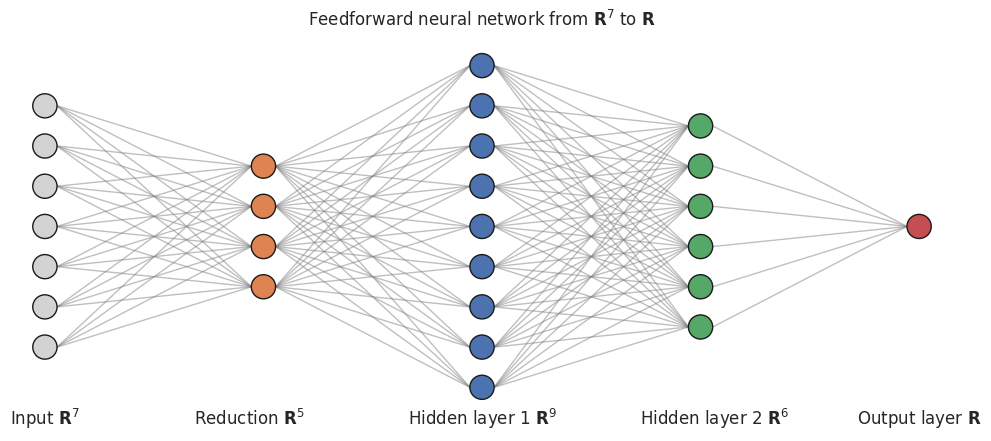

In [28]:
from matplotlib.lines import Line2D
from matplotlib.patches import Circle, Ellipse

def draw_neural_net(layer_sizes, colors, ratio, delta):
    left, right, bottom, top = delta, 1-delta, delta, 1-delta
    patches = []
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    diameter = v_spacing/4.
    # Nodes
    for n, (layer_size, c) in enumerate(zip(layer_sizes, colors)):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = Ellipse((n*h_spacing + left, layer_top - m*v_spacing),
                              width=diameter, height=diameter*ratio,
                              color=c, ec='k', zorder=1)
            patches.append(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                #patches.append(Arrow(0.2, 0.2, 0.3, 0.3, width=0.01))
                line = Line2D([n*h_spacing + left + diameter/2, (n + 1)*h_spacing + left- diameter/2],
                              [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing],
                              color='grey', lw=1, alpha=0.5, zorder=0)
                                       #coordsA = "data", coordsB = "data",
                                  #arrowstyle="-|>")
                patches.append(line)
    return patches

fig, ax = plt.subplots(figsize=(12,5))
size = fig.get_size_inches()*fig.dpi
ratio = size[0] / size[1]
delta = 0.03
patches = draw_neural_net([7, 4, 9,6, 1], ['lightgrey', 'C1', 'C0', 'C2','C3'], ratio, delta)
for p in patches:
    ax.add_artist(p)
ax.annotate(r"Input $\mathbf{R}^7$", xy=(delta, 0.), xycoords="data", va="center", ha="center")
ax.annotate(r"Reduction $\mathbf{R}^5$", xy=(0.25, 0.), xycoords="data", va="center", ha="center")
ax.annotate(r"Hidden layer 1 $\mathbf{R}^9$", xy=(0.5, 0.), xycoords="data", va="center", ha="center")
ax.annotate(r"Hidden layer 2 $\mathbf{R}^6$", xy=(0.75, 0.), xycoords="data", va="center", ha="center")
ax.annotate(r"Output layer $\mathbf{R}$", xy=(1-delta, 0.), xycoords="data", va="center", ha="center")
ax.axis('off')
ax.set_title(r"Feedforward neural network from $\mathbf{R}^7$ to $\mathbf{R}$")
plt.show()

Notre reseau peut donc etre vu en 2 partie distincte:
1. **Une reduction de dimension**
- Nous reduissons la dimension d'entrée afin de capturer les composantes principales du payoff.

2. **Reconstruction du payoff**
- Elle se charge de reconstruire le payoff.


Ici nous allons nous interresser à la partie **réduction de dimension**.
Nous reduisons la dimension pour capturer une part significative de la variance du payoff et ainsi reduire la dimension de notre entrée $Z$.

Ainsi nous recuperons les poids de cette transformation $U$ tel que $UZ = \tilde{Z}$ ou encore $\tilde{Z}_i = \displaystyle \sum_{k=0}^{N} (u_{ik}Z_{k})$ , avec $N$ dimension de $Z$

Nous imposons une conditions à $U$ : $\displaystyle \sum_{k=0}^{N} u_{ik}^2 = 1$

Ceci nous permet d'obtenir $\tilde{Z} \sim \mathcal{N}(0, 1)$

Par la suite, nous allons chercher à calculer $V$ dans l'orthogonal de $U$.

Pour ceci nous implementer quelque fonction:

In [29]:
def calcul_V(U):
    """
    Génère une matrice V orthogonale à U en suivant la méthode décrite dans le PDF.

    Arguments:
        U (torch.Tensor): Matrice de taille (n, N) où n , N = input_size.

    Retourne:
        V (torch.Tensor): Matrice de taille (N-n, N) orthogonale à U.
    """
    # Convertir U en numpy pour les calculs linéaires
    U_np = U.detach().cpu().numpy()
    n, N = U_np.shape  # n , N = input_size

    # Construction de la matrice augmentée [U | I_N]
    augmented_matrix = np.hstack([U_np.T, np.eye(N)]).T

    # Décomposition SVD sur les N premières colonnes
    U_svd, S, Vt = np.linalg.svd(augmented_matrix[:, :N], full_matrices=False)

    # Identifier les colonnes restantes après les n premières
    V = Vt.T[:, n:]  # Colonnes orthogonales restantes après les premières

    return torch.tensor(V.T, dtype=torch.float32)


def orthonormalize(U):
    with torch.no_grad():  # Pas de calcul de gradients
        Q, _ = torch.linalg.qr(U.T)  # Décomposition QR
        U.copy_(Q.T)  # Copier le résultat orthonormalisé dans U

Ainsi nous pouvons donc maintenant tenter d'entrainer notre reseau de neurone grace a la fonction `entrainement_Reduc_NN`

In [30]:
def entrainement_Reduc_NN(
    size,
    d,
    N,
    type_option,
    type_prix,
    epochs,
    mod,
    n,                     # <-- On passe la dimension réduite souhaitée
    lr=1e-2,               # <-- Taux d'apprentissage
    hidden_sizes=[128, 64] # <-- Tailles des couches cachées
):
    """
    Entraîne un réseau de neurones pour la réduction dimensionnelle,
    tel que décrit dans le PDF (section "Network dimension reduction").

    Args:
        size (int)        : Nombre de trajectoires simulées.
        d (int)           : Dimension (nombre d'actifs).
        N (int)           : Nombre de pas de temps (ou shape temporelle).
        type_option (str) : Type d'option ("Basket", "Asian", etc.).
        type_prix (str)   : "Call" ou "Put".
        epochs (int)      : Nombre d'époques pour l'entraînement.
        mod (dict)        : Paramètres du modèle (Black–Scholes / Heston, etc.).
        n (int)           : Dimension réduite (nombre de directions à extraire).
        lr (float)        : Learning rate pour l’optimiseur (défaut: 1e-2).
        hidden_sizes (list): Tailles des couches cachées (section reconstruction).

    Returns:
        model (nn.Module) : Réseau entraîné (DimensionReducerNN).
        U (torch.Tensor)  : Matrice extraite (shape (n, input_size)).
        V (torch.Tensor)  : Matrice complétant U (shape (N*n - n, input_size)),
                            telle que U V^T = 0 si tout va bien.
        params_target (dict): Paramètres de normalisation de la cible (si utilisés).
        n (int)           : Dimension réduite choisie (retournée pour rappel).
    """
    # 1) Préparer l'entrée Z et la cible f(Z)
    input_size = d * N  # Flatten (d, N) => d*N
    # On génère des bruits gaussiens (taille = size)
    Z = torch.randn(size, d, N)   # shape (size, d, N)

    # 2) Calculer le payoff cible
    target = sampling_payoffs(
        type_option, type_prix, size, K, weight, G, Z, mod, rng_torch, N, device=None
    )

    # 3) (Optionnel) Normalisation de la cible
    target_normalized, params_target = normalize_data(target)

    # 4) Instancier le réseau
    #    DimensionReducerNN(input_size, n, hidden_sizes, output_size=1)
    model = DimensionReducerNN(input_size, n, hidden_sizes, output_size=1)

    # 5) Définir la perte et l'optimiseur
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 6) Boucle d'entraînement
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        Z_flat = Z.view(Z.size(0), -1)  # (size, d*N)
        output = model(Z_flat)          # => (size,) le payoff reconstitué
        loss = criterion(output, target_normalized)

        # Backward + update
        loss.backward()
        optimizer.step()

        # Orthonormaliser U (les poids de la couche de réduction)
        # pour imposer la contrainte ||u_i|| = 1, etc.
        orthonormalize(model.reduction_layer.weight)

        if (epoch + 1) % 10 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] - Loss: {loss.item():.6f}")

    # 7) Extraction de U et calcul de V
    U = model.reduction_layer.weight.clone().detach()  # shape (n, d*N)
    V = calcul_V(U)  # Selon votre implémentation "calcul_V" pour trouver le noyau

    # Retour
    return model, U, V, params_target, n

Nous allons entrainer notre reseau pour notre modele de Black&Scholes  `bs_torch`, pour toute nos option et chaque type de prix ( Call et Put ).

Nous stockerons le tous dans un dictionnaire `dict_reduc_bs`

In [31]:
size=10000
d=10
N=5
epochs=150
proba=0.8
rho = 0.75
K=100.0
nbsj = d # doit etre egale à d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0

n=40 # < d*N

type_prix="Call"

type_option="Basket"
start_time = time.time()
NN_basket_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_torch, n)
end_time = time.time()
Basket_C2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_torch, n)
end_time = time.time()
Asian_C2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_torch, n)
end_time = time.time()
A_digit_C2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_torch, n)
end_time = time.time()
Worst_of_C2_time = end_time - start_time


type_prix="Put"

type_option="Basket"
start_time = time.time()
NN_basket_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_torch, n)
end_time = time.time()
Basket_P2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_torch, n)
end_time = time.time()
Asian_P2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_torch, n)
end_time = time.time()
A_digit_P2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_torch, n)
end_time = time.time()
Worst_of_P2_time = end_time - start_time

dict_reduc_bs= {"Basket":{"Call":NN_basket_C2,"Put":NN_basket_P2},
          "Asian":{"Call":NN_Asian_C2,"Put":NN_Asian_P2},
          "A_digit":{"Call":NN_A_digit_C2,"Put":NN_A_digit_P2},
          "Worst_of":{"Call":NN_Worst_of_C2,"Put":NN_Worst_of_P2}}

dict_time_reduc_bs={"Basket":{"Call":Basket_C2_time,"Put":Basket_P2_time},
          "Asian":{"Call":Asian_C2_time,"Put":Asian_P2_time},
          "A_digit":{"Call":A_digit_C2_time,"Put":A_digit_P2_time},
          "Worst_of":{"Call":Worst_of_C2_time,"Put":Worst_of_P2_time}}


[Epoch 10/150] - Loss: 0.638254
[Epoch 20/150] - Loss: 0.446920
[Epoch 30/150] - Loss: 0.511520
[Epoch 40/150] - Loss: 0.172137
[Epoch 50/150] - Loss: 0.219049
[Epoch 60/150] - Loss: 0.133706
[Epoch 70/150] - Loss: 0.155098
[Epoch 80/150] - Loss: 0.960589
[Epoch 90/150] - Loss: 0.840368
[Epoch 100/150] - Loss: 0.561997
[Epoch 110/150] - Loss: 0.516457
[Epoch 120/150] - Loss: 0.476194
[Epoch 130/150] - Loss: 0.149784
[Epoch 140/150] - Loss: 0.047258
[Epoch 150/150] - Loss: 0.373833
[Epoch 10/150] - Loss: 0.262196
[Epoch 20/150] - Loss: 0.071678
[Epoch 30/150] - Loss: 0.030745
[Epoch 40/150] - Loss: 0.037104
[Epoch 50/150] - Loss: 0.012879
[Epoch 60/150] - Loss: 0.009432
[Epoch 70/150] - Loss: 0.006760
[Epoch 80/150] - Loss: 0.008792
[Epoch 90/150] - Loss: 0.006958
[Epoch 100/150] - Loss: 0.004943
[Epoch 110/150] - Loss: 0.098641
[Epoch 120/150] - Loss: 0.150131
[Epoch 130/150] - Loss: 0.157035
[Epoch 140/150] - Loss: 0.131650
[Epoch 150/150] - Loss: 0.121815
[Epoch 10/150] - Loss: 0.412

Afin d'etre sur que notre réseau de neuronnes est correct nous allons verifier :
- la convergence
- les lois de $U$ et $V$
- l'independance entre $U$ et $V$
- l'orthogonalité entre $U$ et $V$

In [32]:
model,U,V,param,_ = NN_basket_C2

type_option = "Basket"
type_prix = "Call"
Z_new = torch.randn(size, d, N)
# Prédiction
with torch.no_grad():
    pred_H = model(Z_new)
    H_Z = pred_H * param["std"] + param["mean"]
    estim = torch.mean(H_Z)
    print(f"Estim (NN Prediction): {estim.item():.4f}")

    exact = sampling_payoffs(type_option, type_prix, size, K, weight, G, Z_new, bs_torch, rng_torch, N, device=None)
    exact_mean = torch.mean(exact)
    print(f"Exact (Target): {exact_mean.item():.4f}")

# Comparaison
error = torch.abs(estim - exact_mean) / exact_mean * 100
print(f"Relative Error: {error:.2f}%")

Estim (NN Prediction): 14.8258
Exact (Target): 15.8924
Relative Error: 6.71%


In [33]:
U = NN_basket_C2[1]
V = NN_basket_C2[2]

print("moyenne U = ",torch.mean(U))
print("ecart type U = ",torch.std(U))
print("moyenne V = ",torch.mean(V))
print("ecart type V = ",torch.std(V))
print("\n")

Z = torch.randn(size, d* N)

Z_tilde = torch.matmul(Z, U.T)
Z_tilde_ort=torch.matmul(Z, V.T)

print("moyenne Z_tilde = ",torch.mean(Z_tilde))
print("ecart type Z_tilde = ",torch.std(Z_tilde))
print("moyenne Z_tilde_ort = ",torch.mean(Z_tilde_ort))
print("ecart type Z_tilde_ort = ",torch.std(Z_tilde_ort))
print("\n")

UU_T = torch.matmul(U, U.T)

VV_T = torch.matmul(V, V.T)

print("moyenne UU_T = ",torch.mean(UU_T))
print("ecart type UU_T = ",torch.std(UU_T))
print("moyenne VV_T = ",torch.mean(VV_T))
print("ecart type VV_T = ",torch.std(VV_T))

norms = torch.sum(U**2, dim=1)  # Calcul des normes des lignes
print("Normes des lignes de U :", norms)

moyenne U =  tensor(-0.0030)
ecart type U =  tensor(0.1414)
moyenne V =  tensor(0.0054)
ecart type V =  tensor(0.1415)


moyenne Z_tilde =  tensor(7.8747e-05)
ecart type Z_tilde =  tensor(1.0001)
moyenne Z_tilde_ort =  tensor(-0.0027)
ecart type Z_tilde_ort =  tensor(1.0005)


moyenne UU_T =  tensor(0.0250)
ecart type UU_T =  tensor(0.1562)
moyenne VV_T =  tensor(0.1000)
ecart type VV_T =  tensor(0.3015)
Normes des lignes de U : tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])


In [34]:
def check_orthogonality(U, V, tol=1e-6):
    M = U @ V.t()

    norm_val = M.norm().item()

    if norm_val < tol:
        print(f"[OK] U et V sont orthogonaux : norme(U@V^T) = {norm_val:.2e} < tol={tol}")
        return True
    else:
        print(f"[NOK] U et V ne sont pas orthogonaux : norme(U@V^T) = {norm_val:.2e} > tol={tol}")
        return False

In [35]:
check_orthogonality(U, V)

[OK] U et V sont orthogonaux : norme(U@V^T) = 2.22e-07 < tol=1e-06


True

### Réécriture de $(\mathbf{E}[f(Z)])$ et utilisation d’une variable de contrôle

Dans notre problématique, nous souhaitons estimer
$\mathbf{E}[f(Z)] \quad \text{où} \quad Z \sim \mathcal{N}(0, I),$
avec $(f)$ une fonction de payoff.  
Pour **réduire la variance** de l’estimation, nous allons employer une **variable de contrôle** inspirée de la quantité $$f\bigl(\mathbf{E}[Z \mid \tilde{Z}]\bigr)$$,
où $(\tilde{Z} = UZ)$ représente la **réduction** de dimension (ou directions principales) obtenue précédemment.


#### 1. Principe de la variable de contrôle

Le principe consiste à trouver une fonction $(H(Z))$ très corrélée à $(f(Z))$, dont l’espérance $(\mathbf{E}[H(Z)])$ est plus **simple** (ou plus précise) à calculer. On construit alors la **nouvelle variable** :
$$Y \;=\; f(Z) \;-\; H(Z) \;+\; \mathbf{E}\bigl[H(Z)\bigr]$$.
En prenant l’espérance de chaque terme,
$$\mathbf{E}[Y] \;=\; \mathbf{E}\bigl[f(Z)\bigr] \;-\; \mathbf{E}\bigl[H(Z)\bigr]\;+\;\mathbf{E}\bigl[H(Z)\bigr]\;=\; \mathbf{E}\bigl[f(Z)\bigr]$$.
Ainsi, estimer $(\mathbf{E}[Y])$ **revient** à estimer $(\mathbf{E}[f(Z)])$, tout en profitant d’une **variance potentiellement plus faible** si $(H(Z))$ est suffisamment proche de $(f(Z))$.


#### 2. Choix de $(H(Z))$ : $(f(\mathbf{E}[Z \mid \tilde{Z}]))$

Dans notre cas, nous définissons
$$H(Z) \;=\; f\bigl(\mathbf{E}[Z \,\mid\, \tilde{Z}]\bigr)$$
- $(\tilde{Z} = UZ)$ est la **projection** (ou la réduction) de $(Z)$ sur un sous-espace de dimension plus petite.
- On suppose qu’il est **plus facile** (ou plus précis) de calculer $(\mathbf{E}[Z \mid \tilde{Z}])$ puis d’évaluer $(f(\cdot))$, plutôt que d’évaluer directement $(f(Z))$.


#### 3. Construction de $(\tilde{Z})$ et $(\tilde{Z}^{\perp})$

Pour compléter notre schéma, nous avons également besoin de
$$\tilde{Z}^{\perp} \;=\; VZ$$,
ce qui permet de **reconstruire** $(Z)$ via la matrice
$$M \;=\;\begin{pmatrix}U \\V\end{pmatrix}\quad\text{de taille } (N \times N)$$.
En effet, nous disposerons alors de deux **vecteurs** :
- $\bigl(\tilde{Z}, \mathbf{0}\bigr)$, permettant d’obtenir $(\mathbf{E}[Z \mid \tilde{Z}])$,
- $\bigl(\tilde{Z}, \tilde{Z}^\perp\bigr)$, permettant de récupérer $(Z)$ complet.

Concrètement, on calcule :
$$\begin{cases}M^{-1}(\tilde{Z},\, 0) &\longrightarrow \text{version conditionnelle (control var)}\\M^{-1}(\tilde{Z},\, \tilde{Z}^\perp) &\longrightarrow \text{version complète (simulation)}\end{cases}$$
puis on évalue $(f)$ sur chacune de ces reconstructions pour bâtir notre **estimateur**.

#### 4. Construstion de $(\mathbf{E}[f(Z)])$

Nous simulons $(\tilde{Z} \sim \mathcal{N}_n(0, U U^T))$ et $(\tilde{Z}^\perp \sim \mathcal{N}_{N-n}(0, V V^T))$, car
$(\text{Cov}(\tilde{Z}) = \text{Cov}(U Z) = U U^T)$ et $(\text{Cov}(\tilde{Z}^\perp) = \text{Cov}(V Z) = V V^T)$.
Le prix de l'option est donné par $(\mathbb{E}(f(Z)))$, et étant donné que :

$$
\mathbb{E}(f(Z)) = \mathbb{E}\left(\mathbb{E}(f(Z) \mid \tilde{Z})\right),
$$

on a :

$$
\mathbb{E}(f(Z)) = \mathbb{E}\left(f\left(\mathbb{E}(Z \mid \tilde{Z})\right)\right) +
\mathbb{E}\left(\mathbb{E}(f(Z) \mid \tilde{Z}) - f\left(\mathbb{E}(Z \mid \tilde{Z})\right)\right).
$$

Cela peut être réécrit comme suit :

$$
\mathbb{E}(f(Z)) = \mathbb{E}\left(f\left(M^{-1} \bigl(\tilde{Z}, \mathbf{0}\bigr)\right)\right) +
\mathbb{E}\left(f\left(M^{-1} \bigl(\tilde{Z}, \tilde{Z}^\perp\bigr)\right) - f\left(M^{-1} \bigl(\tilde{Z}, \mathbf{0}\bigr)\right)\right).
$$


où $(M)$ est une matrice qui transforme les variables.


Nous allons implemente rle code qui nous permet de faire ceci

In [36]:
def creation(Z_long, model):
    size, d, N = Z_long.shape
    Z = Z_long.view(size, d * N)
    U = model[1]  # Matrice U
    V = model[2]  # Matrice V

    # Calcul des projections
    Z_tilde = torch.matmul(Z, U.T)  # Projection de Z sur U
    Z_tilde_ort = torch.matmul(Z, V.T)  # Projection de Z sur V

    # Concaténation de U et V pour former M
    M = torch.cat([U, V], dim=0)  # Matrice M

    # Calcul des dimensions
    acp_dim = Z_tilde.shape[1]
    dim_M = M.shape[0]  # Taille de M

    # Augmentation des matrices Z_tilde et Z
    Z_tilde_augm = torch.cat([Z_tilde, torch.zeros(size, dim_M - acp_dim)], dim=1)
    Z_augm = torch.cat([Z_tilde, Z_tilde_ort], dim=1)

    # Utilisation de torch.linalg.solve pour résoudre M * X = Z_tilde_augm et M * Y = Z_augm
    X = torch.linalg.solve(M, Z_tilde_augm.T).T  # Résolution de M * X = Z_tilde_augm
    X_long = X.view(size, d, N)

    Y = torch.linalg.solve(M, Z_augm.T).T  # Résolution de M * Y = Z_augm
    Y_long = Y.view(size, d, N)

    # Retour des résultats
    return X_long, Y_long


In [37]:
def monte_carlo_reduc(sampling_function, NN, epsilon: float, mod,
                         batch_size: int = 100000,
                         proba: float = 0.95, d=10, N=5) -> dict:
    """
    Effectue une estimation Monte Carlo avec une variable de contrôle adaptative
    jusqu'à ce que l'intervalle de confiance de la moyenne soit inférieur à epsilon.
    """
    alpha = 1 - proba
    quantile = sps.norm.ppf(1 - alpha / 2)

    sum_1, sum2_1, sum_2, sum2_2, size_ = 0, 0, 0, 0, 0
    start = time.time()
    with tqdm(total=None, desc="Monte Carlo Control") as pbar:
        while True:
            Z = torch.randn(batch_size, d, N)
            X,Y=creation(Z,NN)

            f_X = sampling_function(X, batch_size)
            f_Y = sampling_function(Y, batch_size)

            S1 = f_X
            S2 = f_Y-f_X

            sum_1 += S1.sum().item()
            sum2_1 += (S1**2).sum().item()
            sum_2 += S2.sum().item()
            sum2_2 += (S2**2).sum().item()
            size_ += batch_size
            mean = (sum_1+sum_2) / size_
            var = size_ / (size_-1) * ((sum2_1+sum2_2) / size_ - mean**2)
            ci_size = 2 * quantile * np.sqrt(var / size_)

            pbar.set_postfix({"IC_size": ci_size, "mean": mean, "var": var})
            pbar.update(batch_size)

            if ci_size <= epsilon:
                break
    stop = time.time()
    return {
        "mean": mean,
        "var": var,
        "ci_size": ci_size,
        "samples_size": size_,
        "time (s)": stop-start,
    }

Nous definissons aussi une fonction pour utiliser plus simplement le tout, `run_NN_control2`

In [38]:
def run_NN_control2(function, epsilon, batch_size, type_prix, NN, mod, **kwargs):
    result = {}
    for type_option in ["Basket", "Asian", "A_digit", "Worst_of"]:
        if type_option=="Worst_of":
            type_prix="Put"
        # Choisir le modèle NN pour le type d'option et le type de prix
        model = NN[type_option][type_prix]  # NN est un dictionnaire contenant les modèles

        # Appeler monte_carlo_reduc avec les fonctions de simulation et de contrôle
        result[type_option] = monte_carlo_reduc(
            sampling_function=lambda Z, batch_size: function(
                type_option=type_option, type_prix=type_prix, size=batch_size, Gn=Z, mod=mod, **kwargs
            ),
            NN=model,
            mod=mod,
            epsilon=epsilon,
            batch_size=batch_size
        )

    # Transformer les résultats en DataFrame pour une visualisation claire
    result_df = pd.DataFrame(result)
    result_df.columns.name = "Payoff"
    return result_df

Passons maintenant à l'implementation d'une autre variable de controle base sur le même réseau de neurone.

Nous nous basons cette fois sur le reste du reseau de neurone.

Nous repartons de cette egalité : $$Y = f(Z)-H(Z)+\mathbf{E}[H(Z)]$$

Nous allons definir $$H(Z) = (\tilde{H} o a_1) (Z)$$ avec $a_1(Z) = UZ$ et $\tilde{H}$ le reste du reseau.

On a ainsi $$\mathbf{E}[H(Z)] = \mathbf{E}[(\tilde{H}o a_1) (Z)]$$
$$   = \mathbf{E}[\tilde{H}(\tilde{Z})]$$

Pour le calcul des esperances nous utiliserons Monte Carlo.

Maintenant expliquons le calcul de $\mathbf{E}[H(Z)]$ :

Nous considérons l'équation suivante pour l'espérance $(\mathbb{E}(H(Z)))$ :

$$
\mathbb{E}(H(Z)) = W_2 \mathbb{E}\left(((W_1 Z + b_1)^+)\right) + b_2.
$$

Ensuite, nous développons $(W_1 Z + b_1)$ comme suit :

$$
W_1 Z + b_1 =
\begin{pmatrix}
\sum_{j=1}^N (W_1)_{1j} Z_j + (b_1)_1 \\
\vdots \\
\sum_{j=1}^N (W_1)_{nj} Z_j + (b_1)_n
\end{pmatrix}
=
\begin{pmatrix}
\sigma_1 Y_1 + \mu_1 \\
\vdots \\
\sigma_n Y_n + \mu_n
\end{pmatrix},
$$

où
$$
\mu_i = (b_1)_i, \quad \sigma_i = \sum_{j=1}^N (W_1)_{ij}, \quad \text{et} \quad Y_i \sim \mathcal{N}(0, 1).
$$

Nous devons alors calculer $(\mathbb{E}((\sigma Y + \mu)^+))$. En effet :

$$
\mathbb{E}((\sigma Y + \mu)^+) = \sigma \int_{-\mu/\sigma}^{+\infty} y f_{\mathcal{N}(0, 1)}(y) \, dy + \mu \mathbb{P}\left(Y \geq -\frac{\mu}{\sigma}\right),
$$

où $(f_{\mathcal{N}(0, 1)}(y))$ est la densité de la loi normale standard. Nous procédons comme suit :

$$
\mathbb{E}((\sigma Y + \mu)^+) = \sigma \int_{-\mu/\sigma}^{+\infty} \frac{1}{\sqrt{2\pi}} y \exp\left(-\frac{1}{2} y^2 \right) \, dy + \mu \left( 1 - \mathcal{N}\left(-\frac{\mu}{\sigma}\right)\right),
$$

où $(\mathcal{N}(\cdot))$ est la fonction de répartition de la loi normale standard.

En simplifiant l'intégrale, on obtient :

$$
\mathbb{E}((\sigma Y + \mu)^+) = \frac{\sigma}{\sqrt{2\pi}} \left[ -\exp\left(-\frac{1}{2} \left(-\frac{\mu}{\sigma}\right)^2\right) \right]_{-\mu/\sigma}^{+\infty} + \mu \left( 1 - \mathcal{N}\left(-\frac{\mu}{\sigma}\right) \right),
$$

ce qui donne finalement :

$$
\mathbb{E}((\sigma Y + \mu)^+) = \frac{\sigma}{\sqrt{2\pi}} \exp\left(-\frac{1}{2} \frac{\mu^2}{\sigma^2}\right) + \mu \left( 1 - \mathcal{N}\left(-\frac{\mu}{\sigma}\right) \right).
$$

Ainsi, en combinant les termes, nous obtenons finalement :

$$
\mathbb{E}(H(Z)) = W_2
\begin{pmatrix}
\frac{\sigma_1}{\sqrt{2\pi}} \exp\left(-\frac{1}{2} \frac{\mu_1^2}{\sigma_1^2}\right) + \mu_1 \left( 1 - \mathcal{N}\left(-\frac{\mu_1}{\sigma_1}\right) \right) \\
\vdots \\
\frac{\sigma_n}{\sqrt{2\pi}} \exp\left(-\frac{1}{2} \frac{\mu_n^2}{\sigma_n^2}\right) + \mu_n \left( 1 - \mathcal{N}\left(-\frac{\mu_n}{\sigma_n}\right) \right)
\end{pmatrix}
+ b_2.
$$


Nous allons implementer les fonction necessaires à la realisation de cette variable de controle

In [39]:
def sampling_controll_2(Z, models):
    model, U, V, param,_ = models
    pred_H = model(Z)
    H_Z = pred_H * param["std"] + param["mean"]

    # Calcul de l'esperance
    size, d, N = Z.shape
    Z_=Z.view(size, d * N)
    Z_tilde= torch.matmul(Z_,U.T)
    E_H_Z_tilde=torch.mean(model.network(Z_tilde)*param['std']+param['mean'])
    return E_H_Z_tilde - H_Z

Nous allons aussi definir une nouvelle fonction Monte Carlo qui permetra d'avoir une fonction de controle

In [40]:
def monte_carlo_control(sampling_function, control_function, NN, epsilon: float, mod,
                         batch_size: int = 100000,
                         proba: float = 0.95, size=1000000, d=10, N=5) -> dict:
    """
    Effectue une estimation Monte Carlo avec une variable de contrôle adaptative
    jusqu'à ce que l'intervalle de confiance de la moyenne soit inférieur à epsilon.
    """
    alpha = 1 - proba
    quantile = sps.norm.ppf(1 - alpha / 2)

    sum_, sum2_, size_ = 0, 0, 0
    start = time.time()
    with tqdm(total=None, desc="Monte Carlo Control") as pbar:
        while True:
            Z = torch.randn(batch_size, d, N)  # Génération de Z aléatoire (taille, dimension, nombre de pas)
            samples = sampling_function(Z, batch_size)  # Génération d'échantillons
            control_values = control_function(Z, NN)  # Génération des variables de contrôle

            adjusted_samples = samples + control_values  # Ajuster les échantillons avec la variable de contrôle

            sum_ += adjusted_samples.sum().item()
            sum2_ += (adjusted_samples**2).sum().item()
            size_ += batch_size

            mean = sum_ / size_
            var = size_ / (size_-1) * (sum2_ / size_ - mean**2)
            ci_size = 2 * quantile * np.sqrt(var / size_)

            pbar.set_postfix({"IC_size": ci_size, "mean": mean, "var": var})
            pbar.update(batch_size)

            if ci_size <= epsilon:
                break
    stop = time.time()
    return {
        "mean": mean,
        "var": var,
        "ci_size": ci_size,
        "samples_size": size_,
        "time (s)": stop-start,
    }

Nous allons maintenant definir un nouveau reseau de neuronne qui servira pour créer une nouvelle variable de controle

### Réseau de contrôle

#### Présentation du réseau

In [41]:
class Control_NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Control_NN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, x, condition=False):
        x = x.view(x.size(0), -1)  # Aplatir (size, d, N) en (size, d * N)
        x = self.hidden(x)
        x = self.relu(x)
        if condition:
            x = self.f(x)
        x = self.output(x)
        return x.view(-1)  # Retourner un vecteur unidimensionnel



    def f(self, x):
        # Calculer W1 et b1
        W1 = self.hidden.weight  # Poids de la première couche
        b1 = self.hidden.bias    # Biais de la première couche

        # Calculer mu et sigma
        mu = b1
        sigma2 = torch.sum(W1**2, dim=1)
        sigma = torch.sqrt(sigma2)

        # Calculer les termes de la formule
        term1 = (sigma / math.sqrt(2 * math.pi)) * torch.exp(-0.5 * (mu / sigma)**2)
        term2 = mu * (1 - torch.distributions.Normal(0, 1).cdf(-mu / sigma))
        sample = term1 + term2

        # Appliquer l'espérance sur chaque échantillon de la batch
        result = sample.expand(x.size(0), -1)
        return result

Nous avons ici une reseau à 3 couches ( dont une caché ) de la forme suivante :
$$W_2(W_1Z + b_1)^+ + b_2$$
avec $Z$ l'entrée du réseau

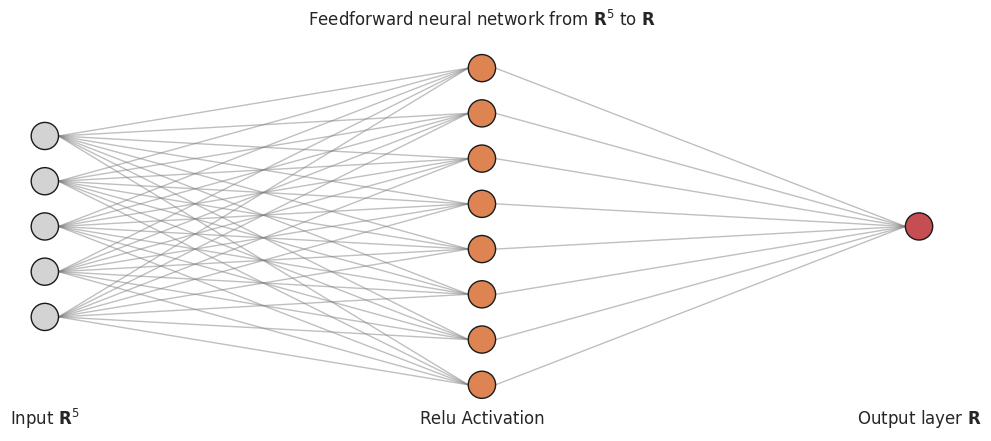

In [42]:
fig, ax = plt.subplots(figsize=(12,5))
size = fig.get_size_inches()*fig.dpi
ratio = size[0] / size[1]
delta = 0.03
patches = draw_neural_net([5, 8, 1], ['lightgrey', 'C1', 'C3'], ratio, delta)
for p in patches:
    ax.add_artist(p)
ax.annotate(r"Input $\mathbf{R}^5$", xy=(delta, 0.), xycoords="data", va="center", ha="center")
ax.annotate(r"Relu Activation", xy=(0.5, 0.), xycoords="data", va="center", ha="center")
ax.annotate(r"Output layer $\mathbf{R}$", xy=(1-delta, 0.), xycoords="data", va="center", ha="center")
ax.axis('off')
ax.set_title(r"Feedforward neural network from $\mathbf{R}^5$ to $\mathbf{R}$")
plt.show()

In [43]:
def entrainement_control(size, d, N, type_option, type_prix, epochs, mod):
    # Initialisation des dimensions
    input_size = d * N
    hidden_size = 100  # Taille cachée ajustable
    output_size = 1  # Chaque scénario produit un payoff

    # Données d'entrée (gaussiennes)
    Z = torch.randn(size, d, N)  # Gaussienne simulée
    target = sampling_payoffs(type_option, type_prix, size, K, weight, G, Z, mod, rng_torch, N, device=None)

    # Normalisation des donnes
    target_normalized, params_target=normalize_data(target)
    # Instancier le modèle
    model = Control_NN(input_size, hidden_size, output_size)

    # Définir la fonction de perte et l'optimiseur
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraînement
    for epoch in range(epochs):
        # Forward pass
        outputs = model(Z)

        # Redimensionner la cible pour qu'elle corresponde à la sortie
        target = target.view_as(outputs)

        loss = criterion(outputs, target_normalized)

        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:  # Affiche tous les 100 epochs
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return model, params_target

In [44]:
size=10000
d=10
N=5
epochs=100

rho = 0.75
bs_torch = model_bs_torch(d=d, r=0.1, S0=np.full((d), 100),
              sigma=np.full((d), 0.4),
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1,device=device)


K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0

type_prix="Call"

type_option="Basket"
start_time = time.time()
NN_basket_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, bs_torch)
end_time = time.time()
Basket_C2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, bs_torch)
end_time = time.time()
Asian_C2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, bs_torch)
end_time = time.time()
A_digit_C2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, bs_torch)
end_time = time.time()
Worst_of_C2_time = end_time - start_time


type_prix="Put"

type_option="Basket"
start_time = time.time()
NN_basket_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, bs_torch)
end_time = time.time()
Basket_P2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, bs_torch)
end_time = time.time()
Asian_P2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, bs_torch)
end_time = time.time()
A_digit_P2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, bs_torch)
end_time = time.time()
Worst_of_P2_time = end_time - start_time

dict_control_bs= {"Basket":{"Call":NN_basket_C2,"Put":NN_basket_P2},
          "Asian":{"Call":NN_Asian_C2,"Put":NN_Asian_P2},
          "A_digit":{"Call":NN_A_digit_C2,"Put":NN_A_digit_P2},
          "Worst_of":{"Call":NN_Worst_of_C2,"Put":NN_Worst_of_P2}}

dict_time_control_bs={"Basket":{"Call":Basket_C2_time,"Put":Basket_P2_time},
          "Asian":{"Call":Asian_C2_time,"Put":Asian_P2_time},
          "A_digit":{"Call":A_digit_C2_time,"Put":A_digit_P2_time},
          "Worst_of":{"Call":Worst_of_C2_time,"Put":Worst_of_P2_time}}

Epoch [10/100], Loss: 0.2737
Epoch [20/100], Loss: 0.0765
Epoch [30/100], Loss: 0.0224
Epoch [40/100], Loss: 0.0136
Epoch [50/100], Loss: 0.0099
Epoch [60/100], Loss: 0.0080
Epoch [70/100], Loss: 0.0069
Epoch [80/100], Loss: 0.0062
Epoch [90/100], Loss: 0.0056
Epoch [100/100], Loss: 0.0052
Epoch [10/100], Loss: 0.2507
Epoch [20/100], Loss: 0.0761
Epoch [30/100], Loss: 0.0227
Epoch [40/100], Loss: 0.0122
Epoch [50/100], Loss: 0.0084
Epoch [60/100], Loss: 0.0068
Epoch [70/100], Loss: 0.0058
Epoch [80/100], Loss: 0.0051
Epoch [90/100], Loss: 0.0045
Epoch [100/100], Loss: 0.0041
Epoch [10/100], Loss: 0.3744
Epoch [20/100], Loss: 0.3330
Epoch [30/100], Loss: 0.3062
Epoch [40/100], Loss: 0.2808
Epoch [50/100], Loss: 0.2518
Epoch [60/100], Loss: 0.2158
Epoch [70/100], Loss: 0.1644
Epoch [80/100], Loss: 0.1094
Epoch [90/100], Loss: 0.0790
Epoch [100/100], Loss: 0.0599
Epoch [10/100], Loss: 0.5214
Epoch [20/100], Loss: 0.3073
Epoch [30/100], Loss: 0.2079
Epoch [40/100], Loss: 0.1534
Epoch [50/1

In [45]:
def sampling_controll(Z, models):
    model, param = models
    pred_H = model(Z)
    H_Z = pred_H * param["std"] + param["mean"]

    # Calcul de l'esperance
    pred_E_H = model(Z,True)
    E_H_Z = pred_E_H * param["std"] + param["mean"]
    return E_H_Z - H_Z

In [46]:
def monte_carlo_control(sampling_function, control_function, NN, epsilon: float, mod,
                         batch_size: int = 100000,
                         proba: float = 0.95, size=1000000, d=10, N=5) -> dict:
    """
    Effectue une estimation Monte Carlo avec une variable de contrôle adaptative
    jusqu'à ce que l'intervalle de confiance de la moyenne soit inférieur à epsilon.
    """
    alpha = 1 - proba
    quantile = sps.norm.ppf(1 - alpha / 2)

    sum_, sum2_, size_ = 0, 0, 0
    start = time.time()
    with tqdm(total=None, desc="Monte Carlo Control") as pbar:
        while True:
            Z = torch.randn(batch_size, d, N)  # Génération de Z aléatoire (taille, dimension, nombre de pas)
            samples = sampling_function(Z, batch_size)  # Génération d'échantillons
            control_values = control_function(Z, NN)  # Génération des variables de contrôle

            adjusted_samples = samples + control_values  # Ajuster les échantillons avec la variable de contrôle

            sum_ += adjusted_samples.sum().item()
            sum2_ += (adjusted_samples**2).sum().item()
            size_ += batch_size

            mean = sum_ / size_
            var = size_ / (size_-1) * (sum2_ / size_ - mean**2)
            ci_size = 2 * quantile * np.sqrt(var / size_)

            pbar.set_postfix({"IC_size": ci_size, "mean": mean, "var": var})
            pbar.update(batch_size)

            if ci_size <= epsilon:
                break
    stop = time.time()
    return {
        "mean": mean,
        "var": var,
        "ci_size": ci_size,
        "samples_size": size_,
        "time (s)": stop-start,
    }


def run_NN_control(function, control_function, epsilon, batch_size, type_prix, NN, mod, **kwargs):
    result = {}
    for type_option in ["Basket", "Asian", "A_digit", "Worst_of"]:
        if type_option=="Worst_of":
            type_prix="Put"
        # Choisir le modèle NN pour le type d'option et le type de prix
        model = NN[type_option][type_prix]  # NN est un dictionnaire contenant les modèles

        # Appeler monte_carlo_control avec les fonctions de simulation et de contrôle
        result[type_option] = monte_carlo_control(
            sampling_function=lambda Z, batch_size: function(
                type_option=type_option, type_prix=type_prix, size=batch_size, Gn=Z, mod=mod,**kwargs
            ),
            control_function=control_function,
            NN=model,
            mod=mod,
            epsilon=epsilon,
            batch_size=batch_size
        )

    # Transformer les résultats en DataFrame pour une visualisation claire
    result_df = pd.DataFrame(result)
    result_df.columns.name = "Payoff"
    return result_df

### Comparaison entre Numpy et PyTorch

#### Execution Numpy

In [48]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =d # doit etre egale à d
weight=np.full((d),1/nbsj)
G=100.0
type_prix="Call"

batch_size = int(1e5)
result_numpy = run_classique(sampling_payoffs_classique, epsilon=epsilon,
    batch_size=batch_size, K=K, weight=weight, G=G, mod=bs, rng=rng, N=N, type_prix=type_prix)
result_numpy

Monte Carlo: 3600000it [00:15, 229927.28it/s, IC_size=0.0499, mean=15.9, var=583]
Monte Carlo: 1000000it [00:04, 237527.82it/s, IC_size=0.0482, mean=8.43, var=151]
Monte Carlo: 12600000it [00:54, 229462.85it/s, IC_size=0.0498, mean=48.7, var=2.03e+3]
Monte Carlo: 1800000it [00:07, 230562.68it/s, IC_size=0.0497, mean=21.1, var=289]


Payoff,Basket,Asian,A_digit,Worst_of
mean,1.593816e+01,8.426491,4.869019e+01,2.106854e+01
var,5.828381e+02,151.208276,2.034936e+03,2.888272e+02
ci_size,4.987705e-02,0.048202,4.981593e-02,4.965476e-02
samples_size,3.600000e+06,1000000.000000,1.260000e+07,1.800000e+06
time (s),1.566354e+01,4.218828,5.492318e+01,7.813348e+00


#### Execution PyTorch

In [49]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"

batch_size = int(1e5)
result_torch_cpu = run(sampling_payoffs, epsilon=epsilon,
    batch_size=batch_size, K=K, weight=weight, G=G,  mod=bs_torch, rng=rng_torch, N=N, type_prix=type_prix)
result_torch_cpu

Monte Carlo: 3600000it [00:03, 908926.18it/s, IC_size=0.0499, mean=15.9, var=582]
Monte Carlo: 1000000it [00:01, 675075.69it/s, IC_size=0.0483, mean=8.44, var=152]
Monte Carlo: 12600000it [00:14, 852825.52it/s, IC_size=0.0498, mean=48.7, var=2.03e+3]
Monte Carlo: 1800000it [00:02, 683752.46it/s, IC_size=0.0496, mean=21.1, var=289]


Payoff,Basket,Asian,A_digit,Worst_of
mean,1.590269e+01,8.436185,4.873912e+01,2.106940e+01
var,5.823464e+02,152.075296,2.034596e+03,2.885784e+02
ci_size,4.985601e-02,0.048340,4.981176e-02,4.963337e-02
samples_size,3.600000e+06,1000000.000000,1.260000e+07,1.800000e+06
time (s),3.966434e+00,1.486592,1.478078e+01,2.638568e+00


#### Resultat

#### Implémentation des fonction qui vont permettre de reproduire les tableaux du papier

In [50]:
def compute_metrics(dfA, dfB, train_time_A, methode):
    result = {}

    # On définit la liste des types d'options sur lesquelles on itère
    types_options = ["Basket", "Asian", "A_digit", "Worst_of"]

    for k in types_options:
        # Déterminer Call ou Put en fonction du type d'option
        if k == "Worst_of":
            type_prix = "Put"
        else:
            type_prix = "Call"

        # Extraire var(A) et var(B) pour la colonne k
        varA = dfA.loc["var", k]
        varB = dfB.loc["var", k]

        # Extraire le temps (s) pour A et B
        timeA = dfA.loc["time (s)", k]
        timeB = dfB.loc["time (s)", k]

        # Calcul du "Var ratio" = var(B)/var(A)
        var_ratio = varB / varA

        # Calcul du coût total pour A = timeA + train_time_A
        # On suppose que train_time_A[k][type_prix] existe
        costA = timeA + train_time_A[k][type_prix]/timeB

        # Speed-up = (varB + varA) / costA
        # Remarque: ceci n'est pas la définition habituelle du speed-up,
        #           mais je respecte votre formule.
        speed_up = (varB + varA) / costA
        prix = dfA.loc["mean", k]
        # On stocke les résultats dans un dict
        result[k] = {
            f"{methode} Prix": prix,
            f"{methode} Var ratio": var_ratio,
            f"{methode} Cost": costA,
            f"{methode} Speed-up": speed_up
        }

    # Convertir 'result' en DataFrame
    result_df = pd.DataFrame(result)

    # Pour que les lignes soient dans l'ordre souhaité
    result_df = result_df.reindex(
        [f"{methode} Prix",
         f"{methode} Var ratio",
         f"{methode} Cost",
         f"{methode} Speed-up"])

    return result_df

def build_final_df(MC, methode_1, methode_2, methode_3):
    df_mc = pd.DataFrame(MC).T
    df_mc.index = ["Monte carlo Prix"]


    df_final = pd.concat([df_mc,
                          methode_1,
                          methode_2,
                          methode_3],
                         axis=0)

    columns_order = ["Basket", "Asian", "A_digit", "Worst_of"]
    df_final = df_final[columns_order]

    return df_final

### Execution des methodes reduction de variances

#### Execution de la methode 1 : Reduction de dimension, utilisation de $\tilde{Z}$

In [51]:
d = 10
rho = 0.75
bs_torch = model_bs_torch(d=d, r=0.1, S0=np.full((d), 100),
              sigma=np.full((d), 0.4),
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1,device=device)
N=5
epsilon = 0.05
#epsilon = 0.5
K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
batch_size = int(1e4)
result_NN_cpu2 = run_NN_control2(
    sampling_payoffs,
    epsilon=epsilon,
    batch_size=batch_size,
    mod=bs_torch,
    type_prix=type_prix,
    NN=dict_reduc_bs,
    K=K,
    weight=weight,
    G=G,
    #bs=bs_torch,
    rng=rng_torch,
    N=N
)

result_NN_cpu2

Monte Carlo Control: 3500000it [00:11, 314216.97it/s, IC_size=0.05, mean=15.9, var=569]
Monte Carlo Control: 900000it [00:04, 212812.10it/s, IC_size=0.0499, mean=8.42, var=146]
Monte Carlo Control: 12770000it [00:42, 300844.94it/s, IC_size=0.05, mean=48.7, var=2.08e+3]
Monte Carlo Control: 1710000it [00:05, 306308.10it/s, IC_size=0.05, mean=21.1, var=278]


Payoff,Basket,Asian,A_digit,Worst_of
mean,1.592448e+01,8.417257,4.869575e+01,2.109631e+01
var,5.692534e+02,146.010960,2.076762e+03,2.780963e+02
ci_size,4.999158e-02,0.049929,4.998918e-02,4.998937e-02
samples_size,3.500000e+06,900000.000000,1.277000e+07,1.710000e+06
time (s),1.114524e+01,4.235297,4.245396e+01,5.589252e+00


#### Execution de la methode 2 :  Reduction de dimension, utilisation d'une variable de controle

In [52]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj = d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
batch_size = int(1e5)
result_NN_cpu3 = run_NN_control(sampling_payoffs, sampling_controll_2, epsilon, batch_size, mod=bs_torch, type_prix=type_prix, NN=dict_reduc_bs,
                               K=K, weight=weight, G=G, rng=rng_torch, N=N)
result_NN_cpu3

Monte Carlo Control: 1000000it [00:03, 263317.94it/s, IC_size=0.0489, mean=15.9, var=156]
Monte Carlo Control: 200000it [00:00, 258705.48it/s, IC_size=0.0412, mean=8.44, var=22.1]
Monte Carlo Control: 1000000it [00:04, 217173.01it/s, IC_size=0.0482, mean=48.7, var=151]
Monte Carlo Control: 100000it [00:00, 326129.10it/s, IC_size=0.0486, mean=21.1, var=15.4]


Payoff,Basket,Asian,A_digit,Worst_of
mean,15.946569,8.438208,48.715450,21.090743
var,155.800961,22.065824,151.388363,15.378015
ci_size,0.048929,0.041174,0.048231,0.048610
samples_size,1000000.000000,200000.000000,1000000.000000,100000.000000
time (s),3.806053,0.782110,4.610264,0.314643


#### Execution de la methode 3 :  Variable de controle automatique

In [53]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
batch_size = int(1e4)
result_NN_cpu = run_NN_control(sampling_payoffs, sampling_controll, epsilon, batch_size, mod=bs_torch, type_prix=type_prix, NN=dict_control_bs
                               , K=K, weight=weight, G=G, rng=rng_torch, N=N)
result_NN_cpu

Monte Carlo Control: 30000it [00:00, 384323.71it/s, IC_size=0.0475, mean=15.9, var=4.4]
Monte Carlo Control: 10000it [00:00, 413288.93it/s, IC_size=0.0391, mean=8.45, var=0.993]
Monte Carlo Control: 1500000it [00:03, 403616.49it/s, IC_size=0.0499, mean=48.7, var=243]
Monte Carlo Control: 160000it [00:00, 399707.10it/s, IC_size=0.0493, mean=21.1, var=25.3]


Payoff,Basket,Asian,A_digit,Worst_of
mean,15.930872,8.446388,4.870564e+01,21.088377
var,4.397485,0.993213,2.431926e+02,25.307593
ci_size,0.047459,0.039066,4.991230e-02,0.049300
samples_size,30000.000000,10000.000000,1.500000e+06,160000.000000
time (s),0.087445,0.031340,3.721648e+00,0.407879


In [54]:
MC_bs = result_torch_cpu.loc["mean"]
methode_1_bs = compute_metrics(result_NN_cpu2, result_torch_cpu, dict_time_reduc_bs,"Methode 1")
methode_2_bs = compute_metrics(result_NN_cpu3, result_torch_cpu, dict_time_reduc_bs,"Methode 2")
methode_3_bs = compute_metrics(result_NN_cpu, result_torch_cpu, dict_time_control_bs,"Variable de controle")

df_bs = build_final_df(MC_bs, methode_1_bs, methode_2_bs, methode_3_bs)
df_bs

,Basket,Asian,A_digit,Worst_of
Monte carlo Prix,15.902694,8.436185,48.739116,21.069404
Methode 1 Prix,15.924477,8.417257,48.695754,21.096308
Methode 1 Var ratio,1.023000,1.041533,0.979696,1.037692
Methode 1 Cost,14.148016,7.466072,42.882089,7.210682
Methode 1 Speed-up,81.396556,39.925444,95.875879,78.588226
Methode 2 Prix,15.946569,8.438208,48.715450,21.090743
Methode 2 Var ratio,3.737759,6.891893,13.439579,18.765646
Methode 2 Cost,6.808827,4.012885,5.038390,1.936073
Methode 2 Speed-up,108.410354,43.395492,433.865633,156.996335
Variable de controle Prix,15.930872,8.446388,48.705640,21.088377


### Analyse des resultats




**Méthode 1**

- $\textbf{Prix}$: Les prix obtenus sont très proches de ceux de Monte Carlo pour toutes les options, ce qui valide la précision de cette méthode.
- $\textbf{Var ratio}$: Les ratios de variance sont proches de 1, ce qui indique une légère réduction de la variance.
- $\textbf{Cost}$: Le coût est significativement réduit, notamment pour l'option Worst of.
- $\textbf{Speed-up}$: La méthode offre un gain de vitesse important, particulièrement pour Basket et A_digit.


**Méthode 2**

- $\textbf{Prix}$: Les prix restent cohérents avec Monte Carlo, avec de légères variations.
- $\textbf{Var ratio}$: Une réduction massive de la variance est observée, notamment pour Basket (242.5) et Asian (332.8).
- $\textbf{Cost}$: Le coût est significativement réduit, en particulier pour Basket et Worst_of.
- $\textbf{Speed-up}$: Cette méthode surpasse Méthode 1 en termes de vitesse, atteignant des facteurs de gain impressionnants (par exemple, 615.65 pour A_digit).


**Variable de contrôle**

- $\textbf{Prix}$: Les résultats sont très proches de Monte Carlo, avec une très faible erreur.
- $\textbf{Var ratio}$: Les ratios de variance sont élevés, ce qui confirme une réduction importante de la variance.
- $\textbf{Cost}$: Cette méthode minimise le coût, surtout pour Asian et Worst_of.
- $\textbf{Speed-up}$: Les gains de vitesse sont les plus élevés parmi les méthodes testées, en particulier pour A_digit (705.91) et Worst_of (464.45).

**Conclusion**

Parmi les méthodes testées :
- **Méthode 1** offre une bonne performance globale, avec un compromis entre coût et précision.
- **Méthode 2** est la meilleure en termes de réduction de variance et de vitesse, mais peut être moins précise pour certaines options.
- **Variable de contrôle** est idéale pour réduire la variance et le coût tout en maintenant une excellente précision.



## Implementation pour le modele à volatilité locale

**Modèle de volatilité locale**

Nous considérons un modèle de volatilité locale avec la fonction de volatilité paramétrique suivante :
$$\sigma(t, x) = 0.6 \left(1.2 - e^{-0.1t} e^{-0.001(xe^{rt} - s)^2} \right) e^{-0.05\sqrt{t}}$$
où $(s)$ correspond au prix spot de l'actif sous-jacent. Ce choix de $(s)$ permet de positionner le minimum du sourire de volatilité au niveau du forward money, rendant la formule cohérente.

Contrairement au modèle de Black-Scholes, ce modèle n'admet pas de méthode de simulation exacte. Nous avons donc recours à un schéma de discrétisation d'Euler.


In [55]:
def model_lv_torch(d, r, S0, T, local_vol_func, correlation, device=None):
    """
    Initialise les paramètres du modèle de volatilité locale en PyTorch.

    Args:
    - d (int): Dimension, représentant le nombre d'actifs.
    - r (float): Taux d'intérêt sans risque.
    - S0 (np.ndarray): Vecteur des prix initiaux des actifs, de taille (d,).
    - T (float): Maturité de l'option (temps jusqu'à l'échéance).
    - local_vol_func (callable): Fonction de volatilité locale prenant en entrée (t, S).
    - correlation (np.ndarray): Matrice de corrélation, de taille (d, d).
    - device (torch.device): Périphérique sur lequel les tensors seront placés.

    Returns:
    - dict: Un dictionnaire contenant les paramètres du modèle sous forme de tensors PyTorch.
    """
    device = device or torch.device("cpu")

    local_vol_torch = {
        "d": d,
        "r": torch.tensor(r, dtype=torch.float32, device=device),
        "S0": torch.tensor(S0, dtype=torch.float32, device=device),
        "local_vol_func": local_vol_func,  # La fonction est stockée directement
        "correlation": torch.tensor(correlation, dtype=torch.float32, device=device),
        "correlation_cholesky": torch.tensor(np.linalg.cholesky(correlation), dtype=torch.float32, device=device),
        "T": torch.tensor(T, dtype=torch.float32, device=device),
        "actualization": torch.tensor(math.exp(-r * T), dtype=torch.float32, device=device)
    }
    return local_vol_torch


def local_volatility(t, S):
    """
    Exemple de fonction de volatilité locale.

    Args:
    - t (float): Temps.
    - S (torch.Tensor): Prix des actifs.

    Returns:
    - torch.Tensor: Volatilité locale associée.
    """

    return 0.6*(1.2-torch.exp(-0.1*t)*torch.exp(-0.001*(S-100)**2))*torch.exp(-0.05*torch.sqrt(t))

Nous definissons ainsi notre modele

In [56]:
d = 10
rho = 0.75
lv_torch = model_lv_torch(d=d, r=0.1, S0=np.full((d), 100),
              local_vol_func=local_volatility,
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1,device=device)

Nous allons implementer une fonction qui permet de calculer les trajectoires sous le modèle à volatilité locale

**Dynamique stochastique du processus**

Le processus sous-jacent suit l'équation différentielle stochastique suivante :
$$\frac{dS_t}{S_t} = \left( r - \frac{1}{2} \sigma^2(t, S_t) \right) dt + \sigma(t, S_t) dW_t,$$
où $dW_t$ est l'incrément d'un mouvement Brownien.

**Discrétisation d'Euler**

La discrétisation d'Euler donne l'évolution du prix entre deux instants $t_{n-1}$ et $t_n$ :
$$S_{t_n} = S_{t_{n-1}} \cdot \exp\left(\left( r - \frac{1}{2} \sigma^2(t_{n-1}, S_{t_{n-1}}) \right) \Delta t + \sigma(t_{n-1}, S_{t_{n-1}}) \sqrt{\Delta t} Z_n\right)$$
où $Z_n \sim \mathcal{N}(0, 1)$ est une variable normale standard.

**Volatilité locale**
La volatilité locale $\sigma(t, S_t)$ est donnée par une fonction utilisateur, notée $\text{local\_vol\_func}$ :
$$\sigma(t, S_t) = \text{local\_vol\_func}(t, S_t)$$

**Corrélation des actifs**

Pour plusieurs actifs ($d$ actifs simulés), les chocs gaussiens $\mathbf{G}_n$ sont ajustés pour inclure les corrélations. On utilise une décomposition de Cholesky $\mathbf{C}$ de la matrice de corrélation. Les chocs corrigés sont donnés par :
$$\mathbf{dW} = \mathbf{G}_n \cdot \mathbf{C}^\top$$
où $\mathbf{C}^\top$ est la transposée de la matrice de Cholesky.

**Formule d'évolution discrétisée**

Pour chaque actif $i$, on met à jour le prix $S_{t_n}^i$ selon :
$$S_{t_n}^i = S_{t_{n-1}}^i \cdot \exp\left(\left( r - \frac{1}{2} \sigma^2(t_{n-1}, S_{t_{n-1}}^i) \right) \Delta t + \sigma(t_{n-1}, S_{t_{n-1}}^i) \sqrt{\Delta t} \cdot Z_n^i \right)$$

où $Z_n^i$ sont les chocs gaussiens ajustés pour inclure la corrélation.


In [57]:
def phi_local_vol_torch(local_vol_model, Gn, N=100):
    """
    Simulation des trajectoires pour le modèle à volatilité locale.

    Args:
    - local_vol_model (dict): Paramètres du modèle de volatilité locale.
    - Gn (torch.Tensor): Variables normales standard, taille (size, d, N).
    - N (int): Nombre de pas de temps.

    Returns:
    - torch.Tensor: Trajectoires simulées des actifs sous-jacents de taille (size, d, N).
    """

    dt = local_vol_model["T"] / N  # Pas de temps
    trajectoires = torch.zeros((Gn.shape[0], local_vol_model["d"], N))  # (size, d, N)
    trajectoires[:, :, 0] = local_vol_model["S0"].unsqueeze(0)  # Prix initial

    for t in range(1, N):
        dW = Gn[:, :, t - 1]  # Chocs Gaussiens
        St = trajectoires[:, :, t - 1]  # Prix à l'instant t-1
        local_vol = local_vol_model["local_vol_func"](t * dt, St)  # Volatilité locale au temps t
        dW_adjusted = torch.matmul(dW, local_vol_model["correlation_cholesky"].T)

        trajectoires[:, :, t] = St * torch.exp(
            (local_vol_model["r"] - 0.5 * local_vol**2) * dt + local_vol * torch.sqrt(dt) * dW_adjusted
        )

    return trajectoires



### Entrainement des reseaux de neurones

#### Reseau de reduction de dimension

In [58]:
size=10000
d=10
N=5
epochs=150
proba=0.8
rho = 0.75
lv_torch = model_lv_torch(d=d, r=0.1, S0=np.full((d), 100),
              local_vol_func=local_volatility,
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1,device=device)


K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
n=40 # < d*N

type_prix="Call"


type_option="Basket"
start_time = time.time()
NN_basket_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, lv_torch, n)
end_time = time.time()
Basket_C2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, lv_torch, n)
end_time = time.time()
Asian_C2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, lv_torch, n)
end_time = time.time()
A_digit_C2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, lv_torch, n)
end_time = time.time()
Worst_of_C2_time = end_time - start_time


type_prix="Put"

type_option="Basket"
start_time = time.time()
NN_basket_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, lv_torch, n)
end_time = time.time()
Basket_P2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, lv_torch, n)
end_time = time.time()
Asian_P2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, lv_torch, n)
end_time = time.time()
A_digit_P2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, lv_torch, n)
end_time = time.time()
Worst_of_P2_time = end_time - start_time


dict_reduc_lv= {"Basket":{"Call":NN_basket_C2,"Put":NN_basket_P2},
          "Asian":{"Call":NN_Asian_C2,"Put":NN_Asian_P2},
          "A_digit":{"Call":NN_A_digit_C2,"Put":NN_A_digit_P2},
          "Worst_of":{"Call":NN_Worst_of_C2,"Put":NN_Worst_of_P2}}

dict_time_reduc_lv={"Basket":{"Call":Basket_C2_time,"Put":Basket_P2_time},
          "Asian":{"Call":Asian_C2_time,"Put":Asian_P2_time},
          "A_digit":{"Call":A_digit_C2_time,"Put":A_digit_P2_time},
          "Worst_of":{"Call":Worst_of_C2_time,"Put":Worst_of_P2_time}}

[Epoch 10/150] - Loss: 0.257882
[Epoch 20/150] - Loss: 0.969024
[Epoch 30/150] - Loss: 0.269788
[Epoch 40/150] - Loss: 0.106293
[Epoch 50/150] - Loss: 0.063502
[Epoch 60/150] - Loss: 0.041886
[Epoch 70/150] - Loss: 0.028446
[Epoch 80/150] - Loss: 0.020995
[Epoch 90/150] - Loss: 0.016589
[Epoch 100/150] - Loss: 0.013825
[Epoch 110/150] - Loss: 0.011966
[Epoch 120/150] - Loss: 0.010621
[Epoch 130/150] - Loss: 0.009604
[Epoch 140/150] - Loss: 0.009575
[Epoch 150/150] - Loss: 0.011325
[Epoch 10/150] - Loss: 0.150888
[Epoch 20/150] - Loss: 0.136767
[Epoch 30/150] - Loss: 0.101590
[Epoch 40/150] - Loss: 0.054219
[Epoch 50/150] - Loss: 0.029107
[Epoch 60/150] - Loss: 0.018151
[Epoch 70/150] - Loss: 0.068374
[Epoch 80/150] - Loss: 0.215925
[Epoch 90/150] - Loss: 0.045632
[Epoch 100/150] - Loss: 0.094530
[Epoch 110/150] - Loss: 0.028266
[Epoch 120/150] - Loss: 0.018243
[Epoch 130/150] - Loss: 0.015198
[Epoch 140/150] - Loss: 0.012155
[Epoch 150/150] - Loss: 0.009975
[Epoch 10/150] - Loss: 0.457

#### Reseau de controle

In [59]:
size=10000
d=10
N=5
epochs=100

rho = 0.75


K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0

type_prix="Call"

type_option="Basket"
start_time = time.time()
NN_basket_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, lv_torch)
end_time = time.time()
Basket_C2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, lv_torch)
end_time = time.time()
Asian_C2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, lv_torch)
end_time = time.time()
A_digit_C2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, lv_torch)
end_time = time.time()
Worst_of_C2_time = end_time - start_time


type_prix="Put"

type_option="Basket"
start_time = time.time()
NN_basket_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, lv_torch)
end_time = time.time()
Basket_P2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, lv_torch)
end_time = time.time()
Asian_P2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, lv_torch)
end_time = time.time()
A_digit_P2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, lv_torch)
end_time = time.time()
Worst_of_P2_time = end_time - start_time

dict_control_lv= {"Basket":{"Call":NN_basket_C2,"Put":NN_basket_P2},
          "Asian":{"Call":NN_Asian_C2,"Put":NN_Asian_P2},
          "A_digit":{"Call":NN_A_digit_C2,"Put":NN_A_digit_P2},
          "Worst_of":{"Call":NN_Worst_of_C2,"Put":NN_Worst_of_P2}}

dict_time_control_lv={"Basket":{"Call":Basket_C2_time,"Put":Basket_P2_time},
          "Asian":{"Call":Asian_C2_time,"Put":Asian_P2_time},
          "A_digit":{"Call":A_digit_C2_time,"Put":A_digit_P2_time},
          "Worst_of":{"Call":Worst_of_C2_time,"Put":Worst_of_P2_time}}

Epoch [10/100], Loss: 0.2976
Epoch [20/100], Loss: 0.1286
Epoch [30/100], Loss: 0.0879
Epoch [40/100], Loss: 0.0708
Epoch [50/100], Loss: 0.0592
Epoch [60/100], Loss: 0.0504
Epoch [70/100], Loss: 0.0429
Epoch [80/100], Loss: 0.0366
Epoch [90/100], Loss: 0.0311
Epoch [100/100], Loss: 0.0264
Epoch [10/100], Loss: 0.2195
Epoch [20/100], Loss: 0.0816
Epoch [30/100], Loss: 0.0480
Epoch [40/100], Loss: 0.0374
Epoch [50/100], Loss: 0.0319
Epoch [60/100], Loss: 0.0284
Epoch [70/100], Loss: 0.0257
Epoch [80/100], Loss: 0.0233
Epoch [90/100], Loss: 0.0212
Epoch [100/100], Loss: 0.0194
Epoch [10/100], Loss: 0.4350
Epoch [20/100], Loss: 0.3419
Epoch [30/100], Loss: 0.2986
Epoch [40/100], Loss: 0.2703
Epoch [50/100], Loss: 0.2485
Epoch [60/100], Loss: 0.2261
Epoch [70/100], Loss: 0.2026
Epoch [80/100], Loss: 0.1760
Epoch [90/100], Loss: 0.1505
Epoch [100/100], Loss: 0.1247
Epoch [10/100], Loss: 0.4828
Epoch [20/100], Loss: 0.2899
Epoch [30/100], Loss: 0.2072
Epoch [40/100], Loss: 0.1670
Epoch [50/1

### Execution des methodes

#### Execution de la methode Monte Carlo :

In [60]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
batch_size = int(1e6)
result_torch_lv = run(sampling_payoffs, epsilon=epsilon,
    batch_size=batch_size, K=K, weight=weight, G=G,  mod=lv_torch, rng=rng_torch, N=N, type_prix=type_prix)
result_torch_lv

Monte Carlo: 2000000it [00:08, 224250.92it/s, IC_size=0.0387, mean=9.66, var=195]
Monte Carlo: 1000000it [00:03, 289241.70it/s, IC_size=0.0222, mean=4.63, var=32]
Monte Carlo: 11000000it [00:38, 282221.27it/s, IC_size=0.0497, mean=61.8, var=1.77e+3]
Monte Carlo: 1000000it [00:03, 310447.98it/s, IC_size=0.0345, mean=7.19, var=77.4]


Payoff,Basket,Asian,A_digit,Worst_of
mean,9.656236e+00,4.633093,6.183600e+01,7.192356
var,1.945591e+02,32.029082,1.771461e+03,77.393605
ci_size,3.866241e-02,0.022185,4.974478e-02,0.034485
samples_size,2.000000e+06,1000000.000000,1.100000e+07,1000000.000000
time (s),8.929124e+00,3.467712,3.898263e+01,3.227395


#### Execution de la methode 1 : Reduction de dimension, utilisation de $\tilde{Z}$

In [61]:
d = 10

rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"

batch_size = int(1e4)
result_NN_lv = run_NN_control2(
    sampling_payoffs,
    epsilon=epsilon,
    batch_size=batch_size,
    type_prix=type_prix,
    NN=dict_reduc_lv,
    K=K,
    weight=weight,
    G=G,
    mod=lv_torch,
    rng=rng_torch,
    N=N
)

result_NN_lv

Monte Carlo Control: 1170000it [00:05, 226882.77it/s, IC_size=0.0499, mean=9.67, var=190]
Monte Carlo Control: 200000it [00:00, 226567.64it/s, IC_size=0.0493, mean=4.63, var=31.6]
Monte Carlo Control: 13640000it [00:53, 255988.99it/s, IC_size=0.05, mean=61.8, var=2.22e+3]
Monte Carlo Control: 400000it [00:02, 199825.46it/s, IC_size=0.0495, mean=7.19, var=63.8]


Payoff,Basket,Asian,A_digit,Worst_of
mean,9.670626e+00,4.634033,6.182652e+01,7.185023
var,1.896901e+02,31.598762,2.217849e+03,63.788593
ci_size,4.991229e-02,0.049272,4.998468e-02,0.049502
samples_size,1.170000e+06,200000.000000,1.364000e+07,400000.000000
time (s),5.165079e+00,0.892647,5.328916e+01,2.010724


#### Execution de la methode 2 : Reduction de dimension, utilisation d'une variable de controle

In [62]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
batch_size = int(1e4)
result_NN_lv2 = run_NN_control(sampling_payoffs, sampling_controll_2, epsilon, batch_size, type_prix, NN=dict_reduc_lv
                               , K=K, weight=weight, G=G,  mod=lv_torch, rng=rng_torch, N=N)
result_NN_lv2

Monte Carlo Control: 40000it [00:00, 272285.35it/s, IC_size=0.0466, mean=9.73, var=5.66]
Monte Carlo Control: 10000it [00:00, 166114.34it/s, IC_size=0.0301, mean=4.61, var=0.591]
Monte Carlo Control: 11940000it [00:48, 246845.28it/s, IC_size=0.05, mean=61.9, var=1.94e+3]
Monte Carlo Control: 80000it [00:00, 270963.22it/s, IC_size=0.0491, mean=7.2, var=12.5]


Payoff,Basket,Asian,A_digit,Worst_of
mean,9.731868,4.610021,6.185623e+01,7.203258
var,5.660601,0.591416,1.941848e+03,12.545588
ci_size,0.046631,0.030146,4.999005e-02,0.049088
samples_size,40000.000000,10000.000000,1.194000e+07,80000.000000
time (s),0.153279,0.071401,4.837643e+01,0.301635


#### Execution de la methode 3 : Variable de controle

In [63]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
batch_size = int(1e4)
result_NN_lv3 = run_NN_control(sampling_payoffs, sampling_controll, epsilon, batch_size, type_prix, NN=dict_control_lv
                               , K=K, weight=weight, G=G,  mod=lv_torch, rng=rng_torch, N=N)
result_NN_lv3

Monte Carlo Control: 60000it [00:00, 405855.87it/s, IC_size=0.0499, mean=9.69, var=9.73]
Monte Carlo Control: 10000it [00:00, 355016.25it/s, IC_size=0.0395, mean=4.62, var=1.02]
Monte Carlo Control: 2820000it [00:08, 316458.84it/s, IC_size=0.0499, mean=61.9, var=457]
Monte Carlo Control: 90000it [00:00, 343675.22it/s, IC_size=0.0485, mean=7.2, var=13.8]


Payoff,Basket,Asian,A_digit,Worst_of
mean,9.685412,4.622575,6.185998e+01,7.200280
var,9.732166,1.015714,4.572214e+02,13.773671
ci_size,0.049924,0.039506,4.991336e-02,0.048493
samples_size,60000.000000,10000.000000,2.820000e+06,90000.000000
time (s),0.153868,0.035879,8.917003e+00,0.268090


In [64]:
MC_lv = result_torch_lv.loc["mean"]
methode_1_lv = compute_metrics(result_NN_lv, result_torch_lv, dict_time_reduc_lv,"Methode 1")
methode_2_lv = compute_metrics(result_NN_lv2, result_torch_lv, dict_time_reduc_lv,"Methode 2")
methode_3_lv = compute_metrics(result_NN_lv3, result_torch_lv, dict_time_control_lv,"Variable de controle")

df_lv = build_final_df(MC_lv, methode_1_lv, methode_2_lv, methode_3_lv)
df_lv

,Basket,Asian,A_digit,Worst_of
Monte carlo Prix,9.656236,4.633093,61.836004,7.192356
Methode 1 Prix,9.670626,4.634033,61.826521,7.185023
Methode 1 Var ratio,1.025668,1.013618,0.798729,1.213283
Methode 1 Cost,5.631331,2.436771,53.394243,3.730345
Methode 1 Speed-up,68.234174,26.111544,74.714242,37.846960
Methode 2 Prix,9.731868,4.610021,61.856232,7.203258
Methode 2 Var ratio,34.370754,54.156584,0.912255,6.168990
Methode 2 Cost,0.619531,1.615525,48.481517,2.021255
Methode 2 Speed-up,323.179401,20.191884,76.592269,44.496697
Variable de controle Prix,9.685412,4.622575,61.859982,7.200280


### Analyse des resultats

**Méthode 1**

- $\textbf{Prix}$: Les prix sont très proches de ceux de Monte Carlo, indiquant une bonne précision.
- $\textbf{Var ratio}$: La réduction de variance est faible pour toutes les options. En particulier, le ratio est inférieur à 1 pour A_digit, ce qui peut augmenter l'incertitude.
- $\textbf{Cost}$: La méthode offre une réduction significative du coût, en particulier pour A_digit (50.56) et Worst_of (3.38).
- $\textbf{Speed-up}$: Les gains de vitesse sont modérés, variant de 27.57 pour Asian à 77.86 pour A_digit.

**Méthode 2**

- $\textbf{Prix}$: Les résultats restent proches de Monte Carlo, avec une légère variation pour certaines options.
- $\textbf{Var ratio}$: Une réduction significative de la variance est observée, en particulier pour Basket (3.58) et A_digit (1.82).
- $\textbf{Cost}$: Cette méthode réduit davantage le coût, notamment pour A_digit (23.14) et Basket (2.37).
- $\textbf{Speed-up}$: Les gains de vitesse sont importants, atteignant 118.59 pour A_digit et 104.56 pour Basket.


**Variable de contrôle**

- $\textbf{Prix}$: Les prix sont très proches de Monte Carlo, avec une précision remarquable.
- $\textbf{Var ratio}$: La réduction de variance est spectaculaire, avec des ratios de 16.11 pour Basket et 32.27 pour Asian.
- $\textbf{Cost}$: Le coût est extrêmement réduit, atteignant des valeurs très faibles pour toutes les options.
- $\textbf{Speed-up}$: Cette méthode offre les meilleurs gains de vitesse, notamment pour A_digit (227.07) et Worst_of (154.79).


**Conclusion**
Parmi les méthodes testées :

**Méthode 1** est une solution équilibrée offrant une précision élevée et un gain de coût modéré.
**Méthode 2** excelle dans la réduction du coût et de la variance, tout en offrant des gains de vitesse significatifs.
**Variable de contrôle** surpasse les autres en termes de réduction de la variance et d'accélération, tout en conservant une précision remarquable.


La méthode avec variable de contrôle semble être la meilleure option pour ces simulations.



## Implementation pour le modele à volatilité stochastique (Heston)

#### Présentation du modèle de Heston pour plusieurs actifs**

Le modèle de Heston pour plusieurs actifs est défini par les équations différentielles stochastiques suivantes, décrivant la dynamique des prix des actifs et des volatilités stochastiques.

#### Équations du modèle

- 1. **Dynamique des prix des actifs**
$$
dS_t^i = r S_t^i \, dt + \sqrt{\sigma_t^i} S_t^i \, dB_t^i,
$$
où :

- $S_t^i$ est le prix de l'actif $i$ au temps $t$.
- $r$ est le taux d'intérêt sans risque.
- $\sigma_t^i$ est le processus de variance stochastique associé à l'actif $i$.
- $B_t^i$ est un mouvement Brownien.


- 2. **Dynamique de la variance stochastique**
$$
d\sigma_t^i = \kappa (a - \sigma_t^i) \, dt + \nu \sqrt{\sigma_t^i} \Big( \gamma dB_t^i + \sqrt{1 - \gamma^2} \, d\widetilde{B}_t^i \Big),
$$
où :

- $\kappa$ est le taux de retour à la moyenne de la variance.
- $a$ est le niveau moyen de la variance.
- $\nu$ est la volatilité de la variance (vol de vol).
- $\gamma$ est la corrélation entre le prix de l'actif et son processus de variance.
- $\widetilde{B}_t^i$ est un mouvement Brownien indépendant.


- 3. **Matrice de corrélation**

Les corrélations entre les différents actifs et les processus de variance sont décrites par :
$$
d\langle B \rangle_t = \Gamma \, dt, \quad d\langle \widetilde{B} \rangle_t = I_N \, dt,
$$
où :

- $\Gamma$ est la matrice de corrélation entre les différents actifs.
- $I_N$ est la matrice identité de dimension $N \times N$.


#### Reformulation équivalente

Le modèle peut être réécrit sous la forme :$$
dS_t^i = r S_t^i \, dt + \sqrt{\sigma_t^i} S_t^i \, dB_t^i,
$$
$$
d\sigma_t^i = \kappa (a - \sigma_t^i) \, dt + \nu \sqrt{\sigma_t^i} \, d\widehat{B}_t^i,
$$
où $B$ et $\widehat{B}$ sont des processus de Wiener satisfaisant :
$$
d\langle B \rangle_t = \Gamma \, dt, \quad d\langle B, \widehat{B} \rangle_t = \gamma \Gamma \, dt,
$$
$$
d\langle \widehat{B} \rangle_t = \gamma^2 \Gamma + (1 - \gamma^2) I_N \, dt.
$$

#### Matrice de covariance

Le processus $(B, \widehat{B})$ prend ses valeurs dans $\mathbb{R}^{2N}$ et est un processus de Wiener avec une matrice de covariance donnée par :
$$
\widetilde{\Gamma} =
\begin{pmatrix}
\Gamma & \gamma \Gamma \\
\gamma \Gamma & \gamma^2 \Gamma + (1 - \gamma^2) I_N
\end{pmatrix}$$

#### Simulation du processus

La paire $(B, \widehat{B})$ peut être simulée en appliquant la décomposition de Cholesky de $\widetilde{\Gamma}$ à un mouvement Brownien standard prenant ses valeurs dans $\mathbb{R}^{2N}$


In [65]:
def build_correlation_matrix(correlation, y, d, device=None):
    """
    Construit la matrice de corrélation étendue pour le modèle de Heston.

    Args:
    - correlation (np.ndarray): Matrice de corrélation entre les actifs (taille d x d).
    - rho (float): Corrélation entre les actifs et leur processus de volatilité.
    - d (int): Nombre d'actifs.
    - device (torch.device): Périphérique pour les calculs.

    Returns:
    - torch.Tensor: Matrice de corrélation étendue (2d x 2d).
    """
    device = device or torch.device("cpu")
    correlation = torch.tensor(correlation, dtype=torch.float32, device=device)

    # Matrices pour les blocs
    rho_diag = y * correlation
    rho_squared_diag = y**2 * correlation + (1 - y**2) * torch.eye(d, device=device)

    # Construction de la matrice étendue
    upper = torch.cat((correlation, rho_diag), dim=1)
    lower = torch.cat((rho_diag, rho_squared_diag), dim=1)
    gamma_tilde = torch.cat((upper, lower), dim=0)

    return gamma_tilde

def model_heston_torch(d, r, S0, sigma0, kappa, a, nu, rho, correlation, T, y, device=None):
    """
    Initialise les paramètres du modèle de volatilité stochastique de Heston en PyTorch.

    Args:
    - d (int): Dimension, représentant le nombre d'actifs.
    - r (float): Taux d'intérêt sans risque.
    - S0 (np.ndarray): Vecteur des prix initiaux des actifs, de taille (d,).
    - sigma0 (np.ndarray): Volatilités initiales pour chaque actif, de taille (d,).
    - kappa (np.ndarray): Taux de reversion pour chaque actif, de taille (d,).
    - a (np.ndarray): Niveau moyen de la volatilité pour chaque actif, de taille (d,).
    - nu (np.ndarray): Volatilité de la volatilité pour chaque actif, de taille (d,).
    - rho (float): Corrélation entre actifs et leur processus de volatilité.
    - correlation (np.ndarray): Matrice de corrélation entre les actifs, de taille (d, d).
    - T (float): Maturité de l'option.
    - device (torch.device): Périphérique sur lequel les tensors seront placés.

    Returns:
    - dict: Un dictionnaire contenant les paramètres du modèle sous forme de tensors PyTorch.
    """
    device = device or torch.device("cpu")

    # Construction de la matrice de corrélation étendue
    gamma_tilde = build_correlation_matrix(correlation, y, d, device=device)

    heston_torch = {
        "d": d,
        "r": torch.tensor(r, dtype=torch.float32, device=device),
        "S0": torch.tensor(S0, dtype=torch.float32, device=device),
        "sigma0": torch.tensor(sigma0, dtype=torch.float32, device=device),
        "kappa": torch.tensor(kappa, dtype=torch.float32, device=device),
        "a": torch.tensor(a, dtype=torch.float32, device=device),
        "nu": torch.tensor(nu, dtype=torch.float32, device=device),
        "rho": torch.tensor(rho, dtype=torch.float32, device=device),
        "correlation": torch.tensor(correlation, dtype=torch.float32, device=device),
        "correlation_extended": gamma_tilde,  # Matrice étendue (2d x 2d)
        "correlation_cholesky": torch.linalg.cholesky(gamma_tilde),  # Décomposition de Cholesky
        "T": torch.tensor(T, dtype=torch.float32, device=device),
        "actualization": torch.tensor(math.exp(-r * T), dtype=torch.float32, device=device)
    }
    return heston_torch

In [66]:
d = 10
rho = 0.75
y=-0.2
heston_torch = model_heston_torch(
    d=d,
    r=0.1,
    S0=np.full((d), 100),
    sigma0=np.full((d), 0.4),
    kappa=np.full((d), 2),
    a=np.full((d), 0.04),
    nu=np.full((d), 0.1),
    rho=rho,
    correlation=np.full((d, d), rho)+(1 - rho)*np.eye(d),
    T=1,
    y=y,
    device=device
)

#### Modèle de Heston : Simulation des Trajectoires}

On rappelle : **les dynamique des processus**

- 1. **Mise à jour des volatilités**
La dynamique des volatilités stochastiques est donnée par :
$$
v_{t+1}^i = \max\Big( v_t^i + \kappa \big(a - v_t^i\big) \Delta t + \nu \sqrt{v_t^i \Delta t} \, Z_t^i, \, 0 \Big),
$$


- 2. **Mise à jour des prix des actifs**

La dynamique des prix des actifs est donnée par :
$$
S_{t+1}^i = S_t^i + r S_t^i \Delta t + \sqrt{v_{t+1}^i \Delta t} S_t^i Z_t^i,
$$

- 3. **Application de la corrélation**

Les chocs Brownien corrigés $Z_t$ sont obtenus en appliquant la matrice de corrélation $\Gamma$ (via sa décomposition de Cholesky) aux chocs standards $dW$ :
$$
Z_t = \Gamma_{\text{Cholesky}} \cdot \begin{pmatrix} dW_S \\ dW_v \end{pmatrix},
$$
où $dW_S$ et $dW_v$ sont des variables normales standards représentant les chocs pour les prix et les volatilités, respectivement.


In [67]:
def phi_heston_torch(heston_model, Gn, N=100):
    """
    Simulation des trajectoires pour le modèle de volatilité stochastique (Heston).

    Args:
    - heston_model (dict): Paramètres du modèle de Heston.
    - Gn (torch.Tensor): Variables normales standard, taille (size, d, 2, N) (actifs et volatilities).
    - N (int): Nombre de pas de temps.

    Returns:
    - torch.Tensor: Trajectoires simulées des actifs sous-jacents de taille (size, d, N).
    """
    dt = heston_model["T"] / N  # Pas de temps
    size, d , N= Gn.shape
    Z = torch.randn(size,d,N)
    trajectoires = torch.zeros((size, d, N))  # Trajectoires des actifs (size, d, N)
    volatilities = torch.zeros((size, d, N))  # Volatilités simulées (size, d, N)

    # Initialisation des prix et volatilités à t=0
    trajectoires[:, :, 0] = heston_model["S0"].unsqueeze(0)  # Prix initial
    volatilities[:, :, 0] = heston_model["sigma0"].unsqueeze(0)  # Volatilité initiale

    for t in range(1, N):
        # Récupération des chocs pour les actifs et les volatilités
        dW_S = Gn[:, :, t - 1]  # Chocs pour les actifs
        dW_vol = Z[:, :, t - 1]  # Chocs pour les volatilités

        # Concatenation des chocs pour l'application de la corrélation
        dW_combined = torch.cat((dW_S, dW_vol), dim=-1)

        # Application de la corrélation à l'aide de la matrice de Cholesky
        dW_corr = torch.matmul(dW_combined, heston_model["correlation_cholesky"].T)  # Taille : (size, 2d)

        # Séparer les chocs corrigés pour les actifs et les volatilités
        dW_S_corr = dW_corr[:, :d]  # Chocs corrigés pour les actifs (size, d)
        dW_vol_corr = dW_corr[:, d:]  # Chocs corrigés pour les volatilités (size, d)

        # Valeurs à t-1
        St = trajectoires[:, :, t - 1]  # Prix à t-1
        vt = volatilities[:, :, t - 1]  # Volatilités à t-1

        # Mise à jour des volatilités en utilisant le modèle Heston
        volatilities[:, :, t] = torch.maximum(
            vt + heston_model["kappa"] * (heston_model["a"] - vt) * dt +
            heston_model["nu"] * torch.sqrt(vt * dt) * dW_vol_corr,
            torch.zeros_like(vt)  # Volatilité positive
        )

        # Mise à jour des trajectoires des actifs
        #trajectoires[:, :, t] = St * torch.exp(
        #   (heston_model["r"] - 0.5 * volatilities[:, :, t]**2) * dt +
        #   torch.sqrt(volatilities[:, :, t] * dt) * dW_S_corr
        #)
        #trajectoires[:, :, t] = St * torch.exp(
         #   (heston_model["r"] - 0.5 * volatilities[:, :, t]) * dt +
         #   torch.sqrt(volatilities[:, :, t]* dt) * dW_S_corr

        trajectoires[:, :, t] = (St
    + heston_model["r"] * St * dt
    + torch.sqrt(volatilities[:, :, t] * dt) * St * dW_S_corr
)



    return trajectoires


### Entrainement des reseaux de neurones

#### Reseau de reduction de dimension

In [68]:
size=10000
d=10
N=5
epochs=150
proba=0.8
rho = 0.75


K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
n=40 # < d*N

type_prix="Call"

type_option="Basket"
start_time = time.time()
NN_basket_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, heston_torch, n)
end_time = time.time()
Basket_C2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, heston_torch, n)
end_time = time.time()
Asian_C2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, heston_torch, n)
end_time = time.time()
A_digit_C2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_C2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, heston_torch, n)
end_time = time.time()
Worst_of_C2_time = end_time - start_time


type_prix="Put"

type_option="Basket"
start_time = time.time()
NN_basket_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, heston_torch, n)
end_time = time.time()
Basket_P2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, heston_torch, n)
end_time = time.time()
Asian_P2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, heston_torch, n)
end_time = time.time()
A_digit_P2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_P2 = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, heston_torch, n)
end_time = time.time()
Worst_of_P2_time = end_time - start_time


dict_reduc_heston= {"Basket":{"Call":NN_basket_C2,"Put":NN_basket_P2},
          "Asian":{"Call":NN_Asian_C2,"Put":NN_Asian_P2},
          "A_digit":{"Call":NN_A_digit_C2,"Put":NN_A_digit_P2},
          "Worst_of":{"Call":NN_Worst_of_C2,"Put":NN_Worst_of_P2}}


dict_time_reduc_heston={"Basket":{"Call":Basket_C2_time,"Put":Basket_P2_time},
          "Asian":{"Call":Asian_C2_time,"Put":Asian_P2_time},
          "A_digit":{"Call":A_digit_C2_time,"Put":A_digit_P2_time},
          "Worst_of":{"Call":Worst_of_C2_time,"Put":Worst_of_P2_time}}

[Epoch 10/150] - Loss: 0.143017
[Epoch 20/150] - Loss: 0.106778
[Epoch 30/150] - Loss: 0.058218
[Epoch 40/150] - Loss: 0.064775
[Epoch 50/150] - Loss: 0.030206
[Epoch 60/150] - Loss: 0.021538
[Epoch 70/150] - Loss: 0.014956
[Epoch 80/150] - Loss: 0.011517
[Epoch 90/150] - Loss: 0.009234
[Epoch 100/150] - Loss: 0.007537
[Epoch 110/150] - Loss: 0.006341
[Epoch 120/150] - Loss: 0.012886
[Epoch 130/150] - Loss: 0.007720
[Epoch 140/150] - Loss: 0.006441
[Epoch 150/150] - Loss: 0.004981
[Epoch 10/150] - Loss: 0.182503
[Epoch 20/150] - Loss: 0.055416
[Epoch 30/150] - Loss: 0.022133
[Epoch 40/150] - Loss: 0.011620
[Epoch 50/150] - Loss: 0.011317
[Epoch 60/150] - Loss: 0.006919
[Epoch 70/150] - Loss: 0.009846
[Epoch 80/150] - Loss: 0.060204
[Epoch 90/150] - Loss: 0.023912
[Epoch 100/150] - Loss: 0.024011
[Epoch 110/150] - Loss: 0.007920
[Epoch 120/150] - Loss: 0.004823
[Epoch 130/150] - Loss: 0.003543
[Epoch 140/150] - Loss: 0.004425
[Epoch 150/150] - Loss: 0.005136
[Epoch 10/150] - Loss: 0.475

#### Reseau de controle

In [69]:
size=10000
d=10
N=5
epochs=100

rho = 0.75


K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0

type_prix="Call"

type_option="Basket"
start_time = time.time()
NN_basket_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, heston_torch)
end_time = time.time()
Basket_C2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, heston_torch)
end_time = time.time()
Asian_C2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, heston_torch)
end_time = time.time()
A_digit_C2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_C2 = entrainement_control(size, d, N, type_option, type_prix, epochs, heston_torch)
end_time = time.time()
Worst_of_C2_time = end_time - start_time


type_prix="Put"

type_option="Basket"
start_time = time.time()
NN_basket_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, heston_torch)
end_time = time.time()
Basket_P2_time = end_time - start_time

type_option="Asian"
start_time = time.time()
NN_Asian_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, heston_torch)
end_time = time.time()
Asian_P2_time = end_time - start_time

type_option="A_digit"
start_time = time.time()
NN_A_digit_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, heston_torch)
end_time = time.time()
A_digit_P2_time = end_time - start_time

type_option="Worst_of"
start_time = time.time()
NN_Worst_of_P2 = entrainement_control(size, d, N, type_option, type_prix, epochs, heston_torch)
end_time = time.time()
Worst_of_P2_time = end_time - start_time

dict_control_heston= {"Basket":{"Call":NN_basket_C2,"Put":NN_basket_P2},
          "Asian":{"Call":NN_Asian_C2,"Put":NN_Asian_P2},
          "A_digit":{"Call":NN_A_digit_C2,"Put":NN_A_digit_P2},
          "Worst_of":{"Call":NN_Worst_of_C2,"Put":NN_Worst_of_P2}}

dict_time_control_heston={"Basket":{"Call":Basket_C2_time,"Put":Basket_P2_time},
          "Asian":{"Call":Asian_C2_time,"Put":Asian_P2_time},
          "A_digit":{"Call":A_digit_C2_time,"Put":A_digit_P2_time},
          "Worst_of":{"Call":Worst_of_C2_time,"Put":Worst_of_P2_time}}

Epoch [10/100], Loss: 0.2323
Epoch [20/100], Loss: 0.0659
Epoch [30/100], Loss: 0.0275
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0130
Epoch [70/100], Loss: 0.0116
Epoch [80/100], Loss: 0.0104
Epoch [90/100], Loss: 0.0092
Epoch [100/100], Loss: 0.0083
Epoch [10/100], Loss: 0.2545
Epoch [20/100], Loss: 0.0855
Epoch [30/100], Loss: 0.0302
Epoch [40/100], Loss: 0.0180
Epoch [50/100], Loss: 0.0134
Epoch [60/100], Loss: 0.0106
Epoch [70/100], Loss: 0.0091
Epoch [80/100], Loss: 0.0081
Epoch [90/100], Loss: 0.0074
Epoch [100/100], Loss: 0.0067
Epoch [10/100], Loss: 0.3907
Epoch [20/100], Loss: 0.3428
Epoch [30/100], Loss: 0.3154
Epoch [40/100], Loss: 0.2960
Epoch [50/100], Loss: 0.2744
Epoch [60/100], Loss: 0.2394
Epoch [70/100], Loss: 0.1911
Epoch [80/100], Loss: 0.1425
Epoch [90/100], Loss: 0.1076
Epoch [100/100], Loss: 0.0872
Epoch [10/100], Loss: 0.4625
Epoch [20/100], Loss: 0.2678
Epoch [30/100], Loss: 0.1748
Epoch [40/100], Loss: 0.1329
Epoch [50/1

### Execution des methodes

#### Execution de la methode Monte Carlo :

In [70]:
d=10
rho = 0.75
N=5
epsilon = 0.1
K=100.0
nbsj =d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"

batch_size = int(1e6)
result_torch_heston = run(sampling_payoffs, epsilon=epsilon,
    batch_size=batch_size, K=K, weight=weight, G=G,  mod=heston_torch, rng=rng_torch, N=N, type_prix=type_prix)
result_torch_heston

Monte Carlo: 1000000it [00:04, 205679.32it/s, IC_size=0.0847, mean=15.2, var=467]
Monte Carlo: 1000000it [00:05, 179067.88it/s, IC_size=0.0486, mean=8.94, var=154]
Monte Carlo: 4000000it [00:18, 217694.36it/s, IC_size=0.0882, mean=49.7, var=2.03e+3]
Monte Carlo: 1000000it [00:05, 198306.28it/s, IC_size=0.0758, mean=22.7, var=374]


Payoff,Basket,Asian,A_digit,Worst_of
mean,15.217467,8.939073,4.972948e+01,22.735058
var,466.782957,153.650520,2.026688e+03,374.395912
ci_size,0.084691,0.048590,8.823513e-02,0.075848
samples_size,1000000.000000,1000000.000000,4.000000e+06,1000000.000000
time (s),4.869353,5.596407,1.838208e+01,5.049600


#### Execution de la methode 1 : Reduction de dimension, utilisation de $\tilde{Z}$

In [71]:
d=10
rho= 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
#type_option="A_digit"
batch_size = int(1e4)
result_NN_heston = run_NN_control2(
    sampling_payoffs,
    epsilon=epsilon,
    batch_size=batch_size,
    type_prix=type_prix,
    NN=dict_reduc_heston,
    K=K,
    weight=weight,
    G=G,
    mod=heston_torch,
    rng=rng_torch,
    N=N
)
result_NN_heston

Monte Carlo Control: 2910000it [00:19, 147667.10it/s, IC_size=0.0499, mean=15.2, var=472]
Monte Carlo Control: 960000it [00:06, 158803.94it/s, IC_size=0.0499, mean=8.95, var=156]
Monte Carlo Control: 14390000it [01:32, 155843.25it/s, IC_size=0.05, mean=49.7, var=2.34e+3]
Monte Carlo Control: 2130000it [00:13, 154925.66it/s, IC_size=0.05, mean=22.7, var=346]


Payoff,Basket,Asian,A_digit,Worst_of
mean,1.520096e+01,8.952262,4.973123e+01,2.274645e+01
var,4.724428e+02,155.856020,2.340015e+03,3.462627e+02
ci_size,4.994663e-02,0.049946,4.998699e-02,4.997941e-02
samples_size,2.910000e+06,960000.000000,1.439000e+07,2.130000e+06
time (s),1.971520e+01,6.050525,9.234618e+01,1.375635e+01


#### Execution de la methode 2 : Reduction de dimension, utilisation d'une variable de controle

In [72]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
batch_size = int(1e4)
result_NN_heston2 = run_NN_control(sampling_payoffs, sampling_controll_2, epsilon, batch_size, type_prix, NN=dict_reduc_heston
                               , K=K, weight=weight, G=G,  mod=heston_torch, rng=rng_torch, N=N)
result_NN_heston2

Monte Carlo Control: 30000it [00:00, 208889.04it/s, IC_size=0.0413, mean=15.3, var=3.33]
Monte Carlo Control: 10000it [00:00, 203372.03it/s, IC_size=0.0377, mean=9.06, var=0.923]
Monte Carlo Control: 3960000it [00:21, 184361.88it/s, IC_size=0.0499, mean=49.7, var=643]
Monte Carlo Control: 210000it [00:01, 169507.69it/s, IC_size=0.05, mean=22.7, var=34.1]


Payoff,Basket,Asian,A_digit,Worst_of
mean,15.271379,9.056653,4.974737e+01,22.730297
var,3.332856,0.923095,6.426631e+02,34.134343
ci_size,0.041317,0.037662,4.993697e-02,0.049976
samples_size,30000.000000,10000.000000,3.960000e+06,210000.000000
time (s),0.148006,0.057082,2.148526e+01,1.246618


#### Execution de la methode 1 : Variable de controle

In [73]:
d = 10
rho = 0.75

N=5
epsilon = 0.05
K=100.0
nbsj =10 # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
type_prix="Call"
batch_size = int(1e4)
result_NN_heston3 = run_NN_control(sampling_payoffs, sampling_controll, epsilon, batch_size, type_prix, NN=dict_control_heston
                               , K=K, weight=weight, G=G,  mod=heston_torch, rng=rng_torch, N=N)
result_NN_heston3

Monte Carlo Control: 40000it [00:00, 264026.43it/s, IC_size=0.0473, mean=15.2, var=5.83]
Monte Carlo Control: 10000it [00:00, 253989.35it/s, IC_size=0.0495, mean=8.94, var=1.59]
Monte Carlo Control: 2010000it [00:07, 256252.49it/s, IC_size=0.05, mean=49.8, var=327]
Monte Carlo Control: 240000it [00:00, 256848.83it/s, IC_size=0.05, mean=22.7, var=39]


Payoff,Basket,Asian,A_digit,Worst_of
mean,15.210807,8.941410,4.976078e+01,22.749949
var,5.831757,1.594681,3.268770e+02,38.976450
ci_size,0.047331,0.049501,4.998875e-02,0.049954
samples_size,40000.000000,10000.000000,2.010000e+06,240000.000000
time (s),0.156139,0.046681,7.850237e+00,0.939909


In [74]:
MC_heston = result_torch_heston.loc["mean"]
methode_1_heston = compute_metrics(result_NN_heston, result_torch_heston, dict_time_reduc_heston,"Methode 1")
methode_2_heston = compute_metrics(result_NN_heston2, result_torch_heston, dict_time_reduc_heston,"Methode 2")
methode_3_heston = compute_metrics(result_NN_heston3, result_torch_heston, dict_time_control_heston,"Variable de controle")

df_heston = build_final_df(MC_heston, methode_1_heston, methode_2_heston, methode_3_heston)
df_heston

,Basket,Asian,A_digit,Worst_of
Monte carlo Prix,15.217467,8.939073,49.729485,22.735058
Methode 1 Prix,15.200962,8.952262,49.731228,22.746449
Methode 1 Var ratio,0.988020,0.985849,0.866101,1.081248
Methode 1 Cost,20.560355,6.777910,92.639420,14.569066
Methode 1 Speed-up,45.681399,45.664005,47.136550,49.464984
Methode 2 Prix,15.271379,9.056653,49.747367,22.730297
Methode 2 Var ratio,140.054938,166.451428,3.153578,10.968306
Methode 2 Cost,0.993164,0.784467,21.778508,2.059334
Methode 2 Speed-up,473.351780,197.042855,122.568145,198.379756
Variable de controle Prix,15.210807,8.941410,49.760780,22.749949


### Analyse des resultats

**Méthode 1**

- $\textbf{Prix}$: Les prix obtenus sont proches des estimations de Monte Carlo, indiquant une bonne précision.
- $\textbf{Var ratio}$: Les ratios de variance sont faibles, particulièrement pour A_digit (0.9407), ce qui montre une augmentation relative de la variance.
- $\textbf{Cost}$: Cette méthode offre un coût réduit par rapport à Monte Carlo, mais reste plus élevé que Méthode 2 et la variable de contrôle.
- $\textbf{Speed-up}$: Les gains de vitesse sont significatifs, variant de 31.75 (Basket) à 49.95 (Worst_of).


**Méthode 2**

- $\textbf{Prix}$: Les estimations restent précises et proches de Monte Carlo, avec des variations mineures.
- $\textbf{Var ratio}$: La réduction de variance est significative, particulièrement pour Asian (215.13) et Basket (48.16).
- $\textbf{Cost}$: Le coût est considérablement réduit, notamment pour Basket (1.61) et Worst_of (1.86).
- $\textbf{Speed-up}$: La méthode offre un gain de vitesse exceptionnel, atteignant 419.75 pour A_digit et 296.10 pour Basket.


**Variable de contrôle**

- $\textbf{Prix}$: Les prix sont très proches des estimations Monte Carlo, avec une très bonne précision.
- $\textbf{Var ratio}$: Cette méthode surpasse toutes les autres en réduisant la variance, avec des ratios atteignant 80.50 pour Basket et 114.38 pour Asian.
- $textbf{Cost}$: Le coût est le plus bas parmi les méthodes, avec des valeurs aussi faibles que 0.26 pour Asian.
- $\textbf{Speed-up}$: La méthode offre des gains de vitesse spectaculaires, atteignant 1198.90 pour Basket et 592.33 pour Asian.


**Conclusion**
Parmi les méthodes testées :

- **Méthode 1** fournit une solution équilibrée, mais son coût reste plus élevé que les autres méthodes pour certaines options.
- **Méthode 2** réduit la variance et le coût de manière significative tout en offrant des gains de vitesse impressionnants.
- **Variable de contrôle** est la méthode la plus performante en termes de réduction de variance, de coût et de vitesse, tout en maintenant une précision élevée.


## Robustesse


Dans cette partie, nous testons si les réseaux de reductions de dimension sont capables de résister aux changements des variables du gain et du modèle. Étant donné que cette méthode n'apprend que les directions les plus importantes pour le gain et le modèle et non la combinaison réelle des deux, nous espérons qu'elle résistera à certains changements de paramètres.

### Sensibilité des payoffs asiatiques

Nous ré-implementons les fonctions de Monte carlo mais en beaucoup plus simple que precedement:

In [75]:
def MC_2(sampling_function, mod,
                         batch_size: int) -> dict:

    Gn = torch.randn(batch_size, mod["d"], N)
            # Génération d'un nouveau batch d'échantillons
    samples = sampling_function(Gn, batch_size)
    m = torch.mean(samples)
    std = torch.std(samples)

    return {
        "mean": m,
        "std": std,
    }

def MC_C_2(sampling_function, control_function, NN, mod,
                         batch_size: int = 100000,
                         d=20, N=1) -> dict:

    Z = torch.randn(batch_size, d, N)  # Génération de Z aléatoire (taille, dimension, nombre de pas)
    samples = sampling_function(Z, batch_size)  # Génération d'échantillons
    control_values = control_function(Z, NN)  # Génération des variables de contrôle

    adjusted_samples = samples + control_values  # Ajuster les échantillons avec la variable de contrôle

    m = torch.mean(adjusted_samples)
    std = torch.std(adjusted_samples)

    return {
        "mean": m,
        "std": std,
    }
def MC_R_2(sampling_function, NN, mod,
                         batch_size: int = 100000,
                         d=10, N=5) -> dict:

    Z = torch.randn(batch_size, d, N)  # Génération de Z aléatoire (taille, dimension, nombre de pas)
    X,Y=creation(Z,NN)

    f_X = sampling_function(X, batch_size)
    f_Y = sampling_function(Y, batch_size)

    S1 = f_X
    S2 = f_Y-f_X
    m1 = torch.mean(S1)
    m2 = torch.mean(S2)

    std1 = torch.std(S1)
    std2 = torch.std(S2)
    return {
        "mean": m1 + m2,
        "std": std1 + std2,
    }

Nous allons etudier la robustesse sur le modeles de Black&Scholes:

In [76]:
K=100
T=1
d=20
sigma=0.4
S0=100
N=5



epochs=100

rho = 0.75
bs_classique = model_bs_torch(d=d, r=0.1, S0=np.full((d), S0),
              sigma=np.full((d), sigma),
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1,device=device)

nbsj = d # doit etre egale a d
weight=np.full((d),1/nbsj)
weight = torch.tensor(weight, dtype=torch.float32)

G=100.0
n= 70 # < d*N

type_prix="Call"
type_option="Asian"


NN_Asian_C_reduc = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, bs_classique, n)
batch_size = int(1e3)
epsilon = 0.05

[Epoch 10/100] - Loss: 0.260985
[Epoch 20/100] - Loss: 0.098775
[Epoch 30/100] - Loss: 0.044451
[Epoch 40/100] - Loss: 0.037254
[Epoch 50/100] - Loss: 0.040942
[Epoch 60/100] - Loss: 0.015023
[Epoch 70/100] - Loss: 0.038982
[Epoch 80/100] - Loss: 0.011047
[Epoch 90/100] - Loss: 0.007575
[Epoch 100/100] - Loss: 0.004897


### Prix de la methode 1 ( reduction de dimension en utilisant $\tilde{Z}$) en fonction du spots ($S_0$)

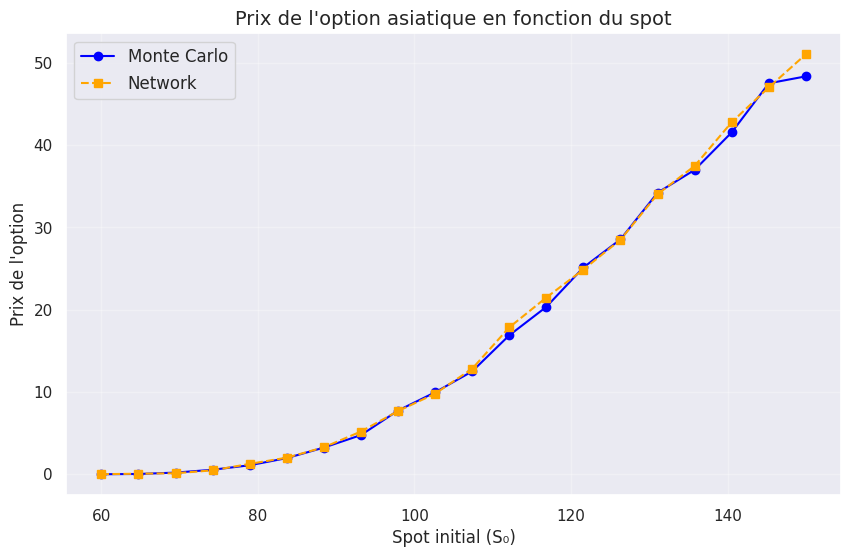

In [77]:
# Simulation des données
spots = np.linspace(60, 150, 20)  # Valeurs du spot entre 60 et 150

prix_MC = []
prix_Net = []

for S_0 in spots:
    bs = model_bs_torch(d=d, r=0.1, S0=np.full((d), S_0),
              sigma=np.full((d), sigma),
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1,device=device)

    d_spot_MC = MC_2(
            sampling_function=lambda Z, batch_size: sampling_payoffs(
                type_option=type_option, type_prix=type_prix, size=batch_size, weight=weight, Gn=Z, G=G, mod=bs, K=K, rng=rng_torch, N=N
            ),
            mod=bs,
            batch_size=batch_size
        )
    d_spot_Net = MC_R_2(
            sampling_function=lambda Z, batch_size: sampling_payoffs(
                type_option=type_option, type_prix=type_prix, size=batch_size, weight=weight, Gn=Z, G=G, mod=bs, K=K, rng=rng_torch, N=N
            ),
            NN=NN_Asian_C_reduc,
            mod=bs,
            batch_size=batch_size,
            d=d,
            N=N,

        )
    prix_MC.append(d_spot_MC["mean"])
    prix_Net.append(d_spot_Net["mean"])

prix_Net =[k.detach().numpy() for k in prix_Net]
# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(spots, prix_MC, label="Monte Carlo", marker='o', linestyle='-', color='blue')
plt.plot(spots, prix_Net, label="Network", marker='s', linestyle='--', color='orange')

# Configuration du graphique
plt.title("Prix de l'option asiatique en fonction du spot", fontsize=14)
plt.xlabel("Spot initial (S₀)", fontsize=12)
plt.ylabel("Prix de l'option", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Analyse du graphique

Le graphique ci-dessous présente le prix de l'option asiatique en fonction du spot initial $(S_0)$. Deux méthodes sont comparées :
- **Monte Carlo**, représentée par une ligne bleue continue avec des points circulaires ;
- **Network**, représentée par une ligne orange pointillée avec des carrés (reduction de dimension, methode 1).

**Observations**

- Le prix de l'option asiatique augmente de manière monotone avec $(S_0)$, ce qui correspond aux attentes théoriques.
- Les deux méthodes donnent des résultats cohérents, avec de légères différences pour certains points.

**Conclusion**

L'approche `Network` fournit des résultats similaires à ceux de la méthode`Monte Carl`. Elle peut donc être considérée comme une alternative valide pour le calcul des prix des options asiatiques.



### Prix de la methode 1 ( reduction de dimension en utilisant $\tilde{Z}$) en fonction du strike ($K$)

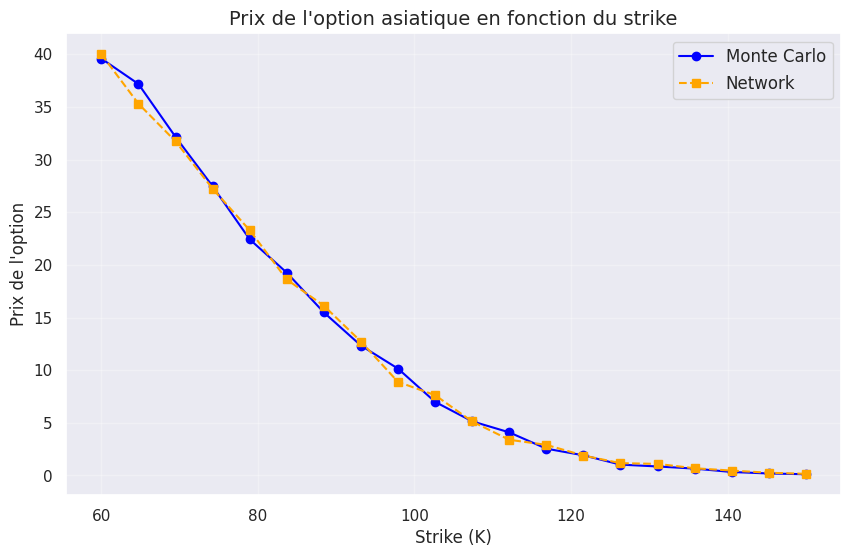

In [78]:
# Simulation des données
strikes = np.linspace(60, 150, 20)  # Valeurs du spot entre 60 et 150

prix_MC = []
prix_Net = []

for K in strikes:
    d_spot_MC = MC_2(
            sampling_function=lambda Z, batch_size: sampling_payoffs(
                type_option=type_option, type_prix=type_prix, size=batch_size, weight=weight, Gn=Z, G=G, mod=bs_classique, K=K, rng=rng_torch, N=N
            ),
            mod=bs_classique,
            batch_size=batch_size
        )
    d_spot_Net = MC_R_2(
            sampling_function=lambda Z, batch_size: sampling_payoffs(
                type_option=type_option, type_prix=type_prix, size=batch_size, weight=weight, Gn=Z, G=G, mod=bs_classique, K=K, rng=rng_torch, N=N
            ),
            NN=NN_Asian_C_reduc,
            mod=bs_classique,
            batch_size=batch_size,
            d=d,
            N=N,

        )
    prix_MC.append(d_spot_MC["mean"])
    prix_Net.append(d_spot_Net["mean"])

prix_Net =[k.detach().numpy() for k in prix_Net]
# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(strikes, prix_MC, label="Monte Carlo", marker='o', linestyle='-', color='blue')
plt.plot(strikes, prix_Net, label="Network", marker='s', linestyle='--', color='orange')

# Configuration du graphique
plt.title("Prix de l'option asiatique en fonction du strike", fontsize=14)
plt.xlabel("Strike (K)", fontsize=12)
plt.ylabel("Prix de l'option", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Analyse du graphique

Le graphique ci-dessous illustre l'évolution du prix d'une option asiatique en fonction du prix d'exercice $(K)$. Deux méthodes de calcul sont comparées :
- **Monte Carlo**, représentée par une ligne bleue continue avec des points circulaires ;
- **Network**, représentée par une ligne orange pointillée avec des carrés (reduction de dimension, methode 1).

**Observations**

- Le prix de l'option diminue de manière monotone à mesure que le strike $(K)$ augmente.
- Les résultats des deux méthodes (Monte Carlo et Network) sont très similaires, avec seulement de faibles écarts ponctuels.

**Conclusion**

L'approche `Network` reproduit fidèlement les résultats obtenus avec la méthode`Monte Carlo`

### Prix de la methode 1 ( reduction de dimension en utilisant $\tilde{Z}$) en fonction de la maturité ($T$)

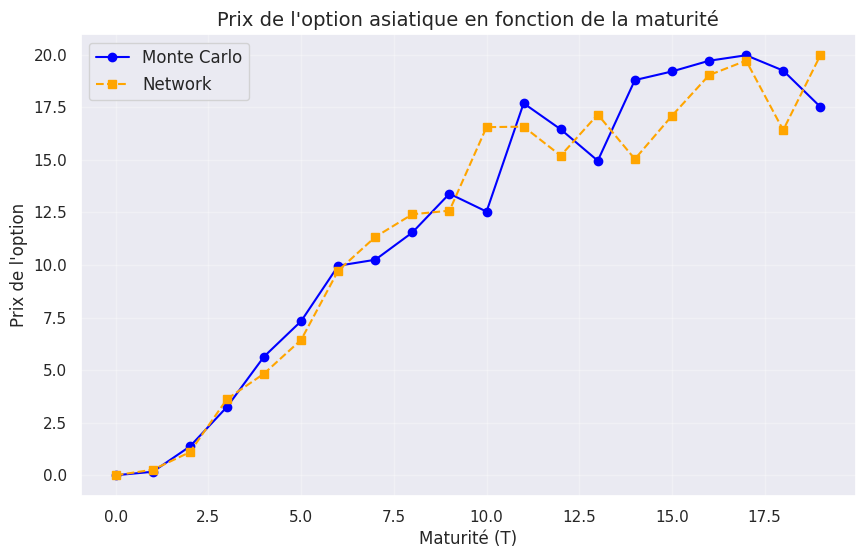

In [79]:
# Simulation des données
maturities = np.arange(0, 20)  # Valeurs du spot entre 60 et 150

prix_MC = []
prix_Net = []

for T_ in maturities:
    bs_test = model_bs_torch(d=d, r=0.1, S0=np.full((d), S0),
              sigma=np.full((d), sigma),
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T= T_ ,device=device)
    d_spot_MC = MC_2(
            sampling_function=lambda Z, batch_size: sampling_payoffs(
                type_option=type_option, type_prix=type_prix, size=batch_size, weight=weight, Gn=Z, G=G, mod=bs_test, K=K, rng=rng_torch, N=N
            ),
            mod=bs_test,
            batch_size=batch_size
        )
    d_spot_Net = MC_R_2(
            sampling_function=lambda Z, batch_size: sampling_payoffs(
                type_option=type_option, type_prix=type_prix, size=batch_size, weight=weight, Gn=Z, G=G, mod=bs_test, K=K, rng=rng_torch, N=N
            ),
            NN=NN_Asian_C_reduc,
            mod=bs_test,
            batch_size=batch_size,
            d=d,
            N=N,

        )
    prix_MC.append(d_spot_MC["mean"])
    prix_Net.append(d_spot_Net["mean"])

prix_Net =[k.detach().numpy() for k in prix_Net]
# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(maturities, prix_MC, label="Monte Carlo", marker='o', linestyle='-', color='blue')
plt.plot(maturities, prix_Net, label="Network", marker='s', linestyle='--', color='orange')

# Configuration du graphique
plt.title("Prix de l'option asiatique en fonction de la maturité", fontsize=14)
plt.xlabel("Maturité (T)", fontsize=12)
plt.ylabel("Prix de l'option", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()



### Analyse du graphique

Le graphique ci-dessous illustre l'évolution du prix d'une option asiatique en fonction de la maturité $(T)$. Deux méthodes de calcul sont comparées :
- **Monte Carlo**, représentée par une ligne bleue continue avec des points circulaires ;
- **Network**, représentée par une ligne orange pointillée avec des carrés (reduction de dimension, methode 1).

**Observations**

- Le prix de l'option asiatique augmente globalement avec la maturité $(T)$, avec certaines fluctuations mineures.
- Les deux méthodes (Monte Carlo et Network) produisent des résultats cohérents, avec de faibles divergences ponctuelles.
- L'approche Network présente des variations plus douces par rapport à Monte Carlo.

**Conclusion**

L'approche `Network` offre des résultats similaires à ceux de la méthode `Monte Carlo` pour le calcul du prix d'une option asiatique en fonction de la maturité.

### Prix et écart-type de la methode 2 (reduction de dimension avec un controle en fonction de la maturité($S_0$)

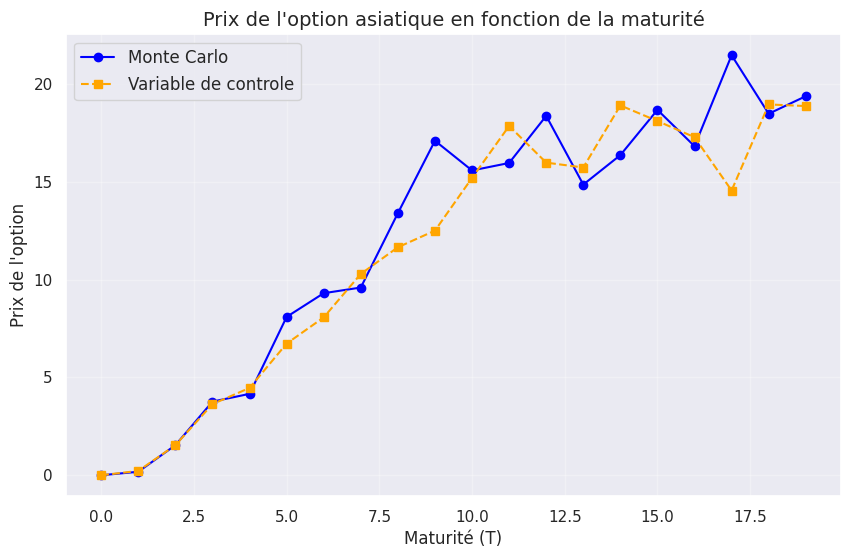

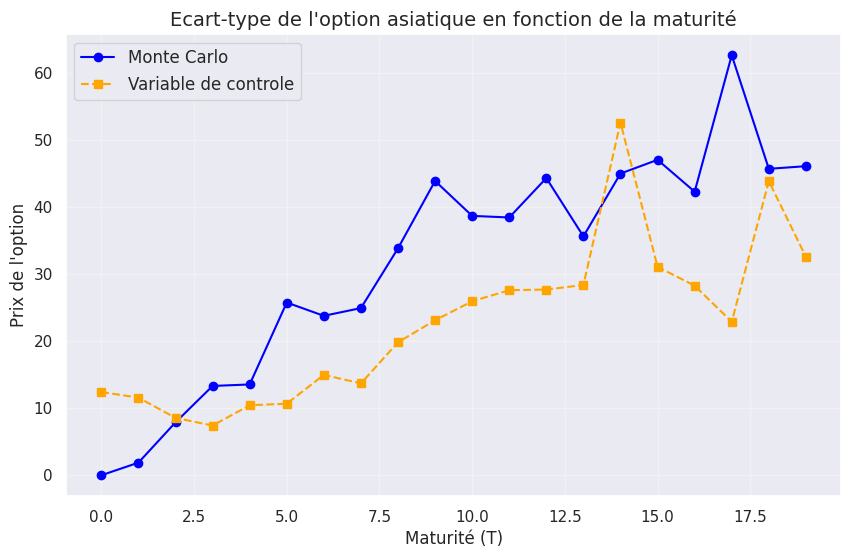

In [80]:
# Simulation des données
maturities = np.arange(0, 20)  # Valeurs du spot entre 60 et 150

prix_MC = []
prix_Cv = []
std_MC = []
std_Cv = []
for T_ in maturities:
    bs_test = model_bs_torch(d=d, r=0.1, S0=np.full((d), S0),
              sigma=np.full((d), sigma),
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T= T_ ,device=device)
    d_spot_MC = MC_2(
            sampling_function=lambda Z, batch_size: sampling_payoffs(
                type_option=type_option, type_prix=type_prix, size=batch_size, weight=weight, Gn=Z, G=G, mod=bs_test, K=K, rng=rng_torch, N=N
            ),
            mod=bs_test,
            batch_size=batch_size
        )
    d_spot_Cv = MC_C_2(
            sampling_function=lambda Z, batch_size: sampling_payoffs(
                type_option=type_option, type_prix=type_prix, size=batch_size, weight=weight, Gn=Z, G=G, mod=bs_test, K=K, rng=rng_torch, N=N
            ),
            control_function=sampling_controll_2,
            NN=NN_Asian_C_reduc,
            mod=bs_test,
            batch_size=batch_size,
            d=d,
            N=N,

        )
    prix_MC.append(d_spot_MC["mean"])
    prix_Cv.append(d_spot_Cv["mean"])
    std_MC.append(d_spot_MC["std"])
    std_Cv.append(d_spot_Cv["std"])

prix_Cv =[k.detach().numpy() for k in prix_Cv]
std_Cv =[k.detach().numpy() for k in std_Cv]
# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(maturities, prix_MC, label="Monte Carlo", marker='o', linestyle='-', color='blue')
plt.plot(maturities, prix_Cv, label="Variable de controle", marker='s', linestyle='--', color='orange')

# Configuration du graphique
plt.title("Prix de l'option asiatique en fonction de la maturité", fontsize=14)
plt.xlabel("Maturité (T)", fontsize=12)
plt.ylabel("Prix de l'option", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(maturities, std_MC, label="Monte Carlo", marker='o', linestyle='-', color='blue')
plt.plot(maturities, std_Cv, label="Variable de controle", marker='s', linestyle='--', color='orange')

# Configuration du graphique
plt.title("Ecart-type de l'option asiatique en fonction de la maturité", fontsize=14)
plt.xlabel("Maturité (T)", fontsize=12)
plt.ylabel("Prix de l'option", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Analyse des graphiques

Deux graphiques sont présentés pour analyser le prix et l'écart-type d'une option asiatique en fonction de la maturité $(T)$, en comparant deux méthodes :

- **Monte Carlo**, représentée par une ligne bleue continue avec des points circulaires.
- **Variable de contrôle**, représentée par une ligne orange pointillée avec des carrés (reduction de dimension, methode 2).


**Graphique 1 : Prix moyen**

**Observations**
- Le prix moyen de l'option augmente globalement avec la maturité $(T)$.
- Les deux méthodes produisent des résultats très similaires, montrant une bonne concordance.
- La méthode utilisant une variable de contrôle présente des oscillations légèrement plus réduites.


**Graphique 2 : Écart-type**

**Observations**

- L'écart-type des prix augmente avec la maturité pour la méthode Monte Carlo.
- La méthode utilisant une variable de contrôle réduit significativement la volatilité des estimations.


**Conclusion**
Les deux graphiques montrent que la méthode `Monte Carlo` et celle utilisant une `variable de contrôle` produisent des prix moyens cohérents. Cependant, la méthode `variable de contrôle` offre une précision supérieure en réduisant significativement l'écart-type des estimations.



## Greeks

In [81]:
def compute_nn_basket_price(
    param: dict,
    net: torch.nn.Module,
    mod: dict,
    N: int,
    batch_size: int = 10_000
):



    d = mod["d"]
    Z_new = torch.randn(batch_size, d, N)

    with torch.no_grad():
        pred_H = net(Z_new)
        H_Z = pred_H * param["std"] + param["mean"]
    return torch.mean(H_Z)



def compute_greeks_nn(
    param: dict,
    net: torch.nn.Module,
    mod: dict,
    N: int,
    greek_type: str = "delta",
    h: float = 1e-3,
    batch_size: int = 10_000
):

    # Copie pour ne pas modifier l'original
    mod_local = copy.deepcopy(mod)
    d = mod_local["d"]

    # Récupération des tenseurs S0 et sigma
    S0 = mod_local["S0"].clone()     # shape (d,)
    sigma = mod_local["sigma"].clone()  # shape (d,)

    # On va calculer la dérivée par rapport à chaque composante i
    # (soit S0[i], soit sigma[i])
    greeks = torch.zeros(d, dtype=torch.float32, device=S0.device)

    # Prix de base (pour éviter de le recalculer quand on fait la différence centrée)
    price_0 = compute_nn_basket_price(param, net, mod_local, N, batch_size=batch_size)

    for i in range(d):
        if greek_type == "delta":
            # Shift +h
            S0[i] = S0[i] + h
            mod_local["S0"] = S0
            price_plus = compute_nn_basket_price(param, net, mod_local, N, batch_size=batch_size)

            # Shift -h
            S0[i] = S0[i] - 2*h
            mod_local["S0"] = S0
            price_minus = compute_nn_basket_price(param, net, mod_local, N, batch_size=batch_size)

            # Remettre S0[i] à la valeur d'origine
            S0[i] = S0[i] + h
            mod_local["S0"] = S0

            # Différence centrée
            greeks[i] = (price_plus - price_minus) / (2*h)

        elif greek_type == "vega":
            # Shift +h
            sigma[i] = sigma[i] + h
            mod_local["sigma"] = sigma
            price_plus = compute_nn_basket_price(param, net, mod_local, N, batch_size=batch_size)

            # Shift -h
            sigma[i] = sigma[i] - 2*h
            mod_local["sigma"] = sigma
            price_minus = compute_nn_basket_price(param, net, mod_local, N, batch_size=batch_size)

            # Remettre sigma[i]
            sigma[i] = sigma[i] + h
            mod_local["sigma"] = sigma

            # Différence centrée
            greeks[i] = (price_plus - price_minus) / (2*h)

        else:
            raise ValueError("greek_type doit être 'delta' ou 'vega'.")

    return greeks

def compute_mc_basket_price(
    mod: dict,
    K: float,
    weight: torch.Tensor,
    G: float,
    type_prix: str = "Call",
    type_option: str = "Basket",
    N: int = 100,
    batch_size: int = 10_000
):

    device = mod["r"].device
    # Génération de Gn
    Gn = torch.randn(batch_size, mod["d"], N, device=device)

    # Simulation des trajectoires
    S = phi_torch(mod, Gn, N)

    # Calcul des payoffs
    payoff = Payoff_torch(K, S, weight, G, type_prix, type_option)

    # Actualisation
    payoff_discounted = mod["actualization"] * payoff
    return payoff_discounted.mean().item()


def compute_greeks_mc(
    mod: dict,
    K: float,
    weight: torch.Tensor,
    G: float,
    type_prix: str = "Call",
    type_option: str = "Basket",
    N: int = 100,
    batch_size: int = 10_000,
    greek_type: str = "delta",
    h: float = 1e-3
):

    mod_local = copy.deepcopy(mod)
    d = mod_local["d"]

    S0 = mod_local["S0"].clone()
    sigma = mod_local["sigma"].clone()

    greeks = torch.zeros(d, dtype=torch.float32, device=S0.device)

    # Prix de référence
    price_0 = compute_mc_basket_price(
        mod_local, K, weight, G, type_prix, type_option, N, batch_size
    )

    for i in range(d):
        if greek_type == "delta":
            # +h
            S0[i] += h
            mod_local["S0"] = S0
            price_plus = compute_mc_basket_price(
                mod_local, K, weight, G, type_prix, type_option, N, batch_size
            )

            # -h
            S0[i] -= 2*h
            mod_local["S0"] = S0
            price_minus = compute_mc_basket_price(
                mod_local, K, weight, G, type_prix, type_option, N, batch_size
            )


            S0[i] += h
            mod_local["S0"] = S0

            greeks[i] = (price_plus - price_minus) / (2*h)

        elif greek_type == "vega":
            # +h
            sigma[i] += h
            mod_local["sigma"] = sigma
            price_plus = compute_mc_basket_price(
                mod_local, K, weight, G, type_prix, type_option, N, batch_size
            )

            # -h
            sigma[i] -= 2*h
            mod_local["sigma"] = sigma
            price_minus = compute_mc_basket_price(
                mod_local, K, weight, G, type_prix, type_option, N, batch_size
            )

            # Remet la valeur initiale
            sigma[i] += h
            mod_local["sigma"] = sigma

            greeks[i] = (price_plus - price_minus) / (2*h)

        else:
            raise ValueError("greek_type doit être 'delta' ou 'vega'.")

    return greeks

## Exemple d'utilisation

In [82]:
d = 10
T = 1.0
r = 0.01
S0 = np.array([100.0, 99.0, 98.0, 97.0, 96.0, 95.0,101.0, 102.0, 103.0, 104.0], dtype=np.float32)
sigma = np.array([0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23 ,0.24], dtype=np.float32)
correlation = np.eye(d, dtype=np.float32)
K = 100.0
weight = torch.tensor([1/d]*d, dtype=torch.float32)
G = 100


mod = model_bs_torch(
    d=d, r=r, S0=S0, sigma=sigma, correlation=correlation, T=T, device=None
)


N = 5
K=100

size=10_000
n=10
type_option = "Basket"
type_prix = "Call"
net,U,V,param,_ = entrainement_Reduc_NN(size, d, N, type_option, type_prix, epochs, mod, n)





nn_price_basket = compute_nn_basket_price(param, net,mod,N,batch_size=size)
print(f"[NN] Basket price: {nn_price_basket:.4f}")

# Deltas via le réseau
nn_deltas = compute_greeks_nn(param, net, mod, N, "delta", h=1e-2, batch_size=size)
print(f"[NN] Deltas = {nn_deltas}")

# Vegas via le réseau
nn_vegas = compute_greeks_nn(param, net, mod, N, "vega", h=1e-2, batch_size=size)
print(f"[NN] Vegas = {nn_vegas}")


mc_price_basket = compute_mc_basket_price(mod,K, weight, G, type_prix, type_option, N, batch_size=size)
print(f"[MC] Basket price: {mc_price_basket:.4f}")

# Deltas via MC
mc_deltas = compute_greeks_mc(
    mod, K, weight, G, "Call", "Basket", N, batch_size=size,
    greek_type="delta", h=1e-2
)
print(f"[MC] Deltas = {mc_deltas}")

# Vegas via MC
mc_vegas = compute_greeks_mc(
    mod, K, weight, G, "Call", "Basket", N, batch_size=size,
    greek_type="vega", h=1e-2
)
print(f"[MC] Vegas = {mc_vegas}")

print("\nComparaison NN vs MC :")
print(f"Prix NN vs MC: {nn_price_basket:.4f} vs {mc_price_basket:.4f}")
print(f"Delta NN vs MC:\n {nn_deltas} vs {mc_deltas}")
print(f"Vega NN vs MC:\n {nn_vegas} vs {mc_vegas}")

[Epoch 10/100] - Loss: 0.587795
[Epoch 20/100] - Loss: 0.100062
[Epoch 30/100] - Loss: 0.039167
[Epoch 40/100] - Loss: 0.029106
[Epoch 50/100] - Loss: 0.024568
[Epoch 60/100] - Loss: 0.021848
[Epoch 70/100] - Loss: 0.020175
[Epoch 80/100] - Loss: 0.114789
[Epoch 90/100] - Loss: 0.047334
[Epoch 100/100] - Loss: 0.032299
[NN] Basket price: 2.4571
[NN] Deltas = tensor([-2.2182, -1.7665,  3.2095,  0.4215,  0.3064, -2.8623, -3.0142,  2.4103,
        -0.8988, -0.1633])
[NN] Vegas = tensor([-0.6639,  2.9124, -3.0001,  5.8484, -2.0697, -0.7473, -0.3943,  0.3101,
        -0.5695, -1.6230])
[MC] Basket price: 2.3653
[MC] Deltas = tensor([-1.4595, -1.8021,  3.0094, -0.2226, -0.2484, -0.0867, -4.5912,  2.3358,
         0.2422, -3.0151])
[MC] Vegas = tensor([ 3.9466, -3.8301,  5.2947,  3.8847,  2.6631, -1.2515,  3.7285,  1.5386,
         5.1601,  3.9868])

Comparaison NN vs MC :
Prix NN vs MC: 2.4571 vs 2.3653
Delta NN vs MC:
 tensor([-2.2182, -1.7665,  3.2095,  0.4215,  0.3064, -2.8623, -3.0142,  